In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import time
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()


# Dataset info

In [4]:
analysis_type='split_pupil'

responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
trial_epoch='plushalf'

experiment='blobs'
C_value=None
n_iterations=100
overlap_thr=None #0.5
n_processes=1

options=['-E', experiment, '-R', responsive_test, '-r', responsive_thr, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value, '-X', analysis_type, '--epoch=%s' % trial_epoch]

In [5]:
#### Extract options
opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = opts.rootdir
create_new = opts.create_new
verbose=opts.verbose

# Pick dataset ------------------------------------ 
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
if responsive_test=='None':
    responsive_test=None
responsive_thr = float(opts.responsive_thr) if responsive_test is not None else 0.05 #10

# Classifier info ---------------------------------
experiment = opts.experiment #'blobs'
class_a=int(opts.class_a) #0
class_b=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
trial_epoch = opts.trial_epoch

class_name='morphlevel'
train_classes = [class_a, class_b]
print("Class: %s, %s" % (class_name, str(train_classes)))

analysis_type=opts.analysis_type

# CV ----------------------------------------------
test_split=0.2
cv_nfolds=5
C_value=opts.C_value
do_cv = C_value is None
m0=0
m100=106

print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))

# Dataset filtering --------------------------------
filter_fovs = True
remove_too_few = True
min_ncells = 10 if remove_too_few else 0
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)
has_rfs = overlap_thr is not None

stim_filterby = None # 'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'

# Create data ID for labeling figures with data-types
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
stimfilter_str = 'filter_%s_%s' % (stim_filterby, g_str)
data_id = '|'.join([traceid, stimfilter_str, response_str])
print(data_id)


match_distns = opts.match_distns
if analysis_type=='single_cells':
    match_distns = False
match_str = 'matchdistns_' if match_distns else ''

# Pupil -------------------------------------------
pupil_feature='pupil_area'
pupil_alignment='trial'
pupil_epoch='pre'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------

# Alignment 
iti_pre=1.
iti_post=1.
stim_dur=1.

# RF stuff 
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05

Class: morphlevel, [0, 106]
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None
traces001|filter_None_blobsonly|dff_ROC-thr-0.05


In [6]:
train_str = '%s_iter-%i' % (analysis_type, n_iterations)
print(train_str, trial_epoch)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()

('split_pupil_iter-100', 'plushalf')


# Output dir

In [7]:
#### Output dir
analysis_type = 'split_pupil'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil


# Get metadata for experiment type

In [8]:
#### Get metadata for experiment type
print("Filtering <%s> by: %s" % (experiment, str(stim_filterby)))
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
dsets, keys_by_area = aggr.experiment_datakeys(experiment=experiment, 
                            experiment_only=False,stim_filterby=stim_filterby,
                            has_gratings=has_gratings, has_rfs=has_rfs, )
stim_datakeys = dsets['datakey'].unique()


Filtering <blobs> by: None
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets


# Get source (input) data

In [31]:
#responsive_test='ROC'
#responsive_thr=10. if responsive_test=='nstds' else 0.05
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
stack_neuraldf = analysis_type in ['by_ncells']

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li'] #, 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li            585   585       585      585      585     585        585
Lm           1127  1127      1127     1127     1127    1127       1127
V1           1251  1251      1251     1251     1251    1251       1251

# Pupil

In [10]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [11]:
# def count_pupil_n_trials_missing(pupil_train_counts):
#     '''
#     expects pupil_train_counts to be a dataframe of N train trials
#     Old: (key=datakey, value=pupil data df)
#     '''
#     c_=[]
#     #for datakey, pdata in pupildata.items():
#     for datakey, pdata in pupil_train_counts.groupby(['datakey']):
#         ntrials_t = pdata.shape[0]
#         ntrials_p = pdata.dropna().shape[0]
#         c_.append(pd.Series({'datakey': datakey, 'ntrials_total': ntrials_t, 'ntrials_pass': ntrials_p}))
#     pupil_counts = pd.concat(c_, axis=1).T
#     pupil_counts['ntrials_missing'] = pupil_counts['ntrials_total'] - pupil_counts['ntrials_pass']
#     pupil_counts.index = pupil_counts['datakey']
#     pupil_counts = pupil_counts.drop(['datakey'], axis=1)
    
#     return pupil_counts


# def count_pupil_training_trials(ndata, pdata, sdf, class_name='morphlevel', class_a=0, class_b=106,
#                                 train_transform_name=None, train_transform_value=None):
#     '''
#     Return subset of trials for training set or decoding subset.
#     ndata: df (neural df for 1 dset)
#     pdata: df (pupil df for 1 dset)
#     '''
#     #noncell_cols=['visual_area', 'datakey', 'config', 'trial']
#     ndata['trial']=ndata.index
#     assert pdata.shape[0] == ndata.shape[0], "Incorrect trial #s included"
#     assert sorted(pdata['trial'].unique()) == sorted(ndata['trial'].unique()), \
#             "Pupil trials are not the same as neural trials"

#     # Get train configs
#     #class_a=0; class_b=106;
#     if train_transform_name is not None and train_transform_value is not None:
#         if not isinstance(train_transform_value, (list, np.array)):
#             train_transform_value = [train_transform_value]
#         train_configs = sdf[sdf[class_name].isin([class_a, class_b]) &
#                            sdf[train_transform_name].isin(train_transform_value)].index.tolist()
#     else:
#         train_configs = sdf[sdf[class_name].isin([class_a, class_b])].index.tolist()
#     train_trials = sorted(ndata[ndata['config'].isin(train_configs)]['trial'].unique())

#     sub_pdata = pdata[pdata['trial'].isin(train_trials)] #.dropna()
#     sub_ndata = ndata[ndata['trial'].isin(train_trials)] #.dropna()
    
#     return sub_ndata, sub_pdata

In [32]:
pupil_feature = 'pupil_fraction'
pupil_epoch = 'pre'
alignment_type='trial'
n_cuts=3
redo_pupil=False 

pupil_snapshot=391800
pupil_framerate=20.   
iti_pre=1.
iti_post=1.
stim_dur=1.

#if 'pupil' in analysis_type:
pupildata, missing_pupil = dlcutils.get_aggregate_pupildfs(experiment=experiment, feature_name=pupil_feature, 
                                        alignment_type=alignment_type, trial_epoch=pupil_epoch,
                                        iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                        in_rate=pupil_framerate, out_rate=pupil_framerate,
                                        snapshot=pupil_snapshot, create_new=redo_pupil, return_missing=True)
# print('20190322_JC073_fov1' in pupildata.keys())
print(missing_pupil)


>>>> Loaded aggregate pupil dataframes.
Segmentation: missing 9 dsets
['20190315_JC070_fov1']


In [33]:
pupildata['20191018_JC113_fov1'].shape, MEANS['20191018_JC113_fov1'].shape

((2350, 6), (2850, 89))

In [34]:
pupildata['20191018_JC113_fov1'].head()

trial  frame   pupil_area  frame_int  frame_ix  pupil_fraction
0    1.0    9.5  2909.712504        9.5       9.5        0.421044
1    2.0    9.5  1300.907930        9.5       9.5        0.188245
2    3.0    9.5  1325.695366        9.5       9.5        0.191832
3    4.0    9.5  1849.303064        9.5       9.5        0.267600
4    5.0    9.5  1871.390865        9.5       9.5        0.270796

In [27]:
# pupildata = add_stimuli_to_pupildf(pupildata, MEANS, SDF)

## Aggregate pupildata into df, match to neuraldata

In [35]:
pupildata[pupildata.keys()[0]].head()

trial  frame  pupil_area  frame_int  frame_ix  pupil_fraction
0    1.0    9.5  593.718311        9.5       9.5        0.582607
1    2.0    9.5  412.658117        9.5       9.5        0.404935
2    3.0    9.5  409.877847        9.5       9.5        0.402207
3    4.0    9.5  451.443446        9.5       9.5        0.442995
4    5.0    9.5  348.668212        9.5       9.5        0.342143

In [36]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.pyc'>

In [37]:
pupildata0, MEANS, bad_alignment = dlcutils.add_stimuli_to_pupildf(pupildata, MEANS, SDF, 
                                                                   verbose=False, return_valid_only=False)

for (k, n_off) in bad_alignment:
    print(k)
    pupildata0.pop(k, None)
    

ERROR: 20191018_JC113_fov1 -- bad trial alignment? Neural trials != pupil trials.
20191018_JC113_fov1


In [38]:
count_cols = ['datakey', 'n_trials_total', 'n_trials_dropped', 'n_train_trials', 'n_train_trials_dropped']
pupil_counts = pd.concat([pdata[count_cols].drop_duplicates().copy() \
                          for dk, pdata in pupildata0.items()]).reset_index(drop=True)
pupil_counts['fraction_missing_total'] = pupil_counts['n_trials_dropped']\
                                            .divide(pupil_counts['n_trials_total'].astype(float))
pupil_counts['fraction_missing_train'] = pupil_counts['n_train_trials_dropped']\
                                            .divide(pupil_counts['n_train_trials'].astype(float))
pupil_counts['n_train_trials_pass'] = pupil_counts['n_train_trials'] - pupil_counts['n_train_trials_dropped']
pupil_counts.sort_values(by='fraction_missing_train', ascending=False).head()

datakey  n_trials_total  n_trials_dropped  n_train_trials  \
2   20190319_JC067_fov1            1350              1070             300   
20  20190602_JC091_fov1            1499               814             299   
5   20190510_JC083_fov1            1750               959             350   
26  20190320_JC067_fov1            1350               695             300   
17  20190606_JC091_fov1            1625               823             325   

    n_train_trials_dropped  fraction_missing_total  fraction_missing_train  \
2                      238                0.792593                0.793333   
20                     165                0.543029                0.551839   
5                      191                0.548000                0.545714   
26                     160                0.514815                0.533333   
17                     158                0.506462                0.486154   

    n_train_trials_pass  
2                    62  
20                  134  
5                   159  
26                  140  
17                  167

<IPython.core.display.Javascript object>


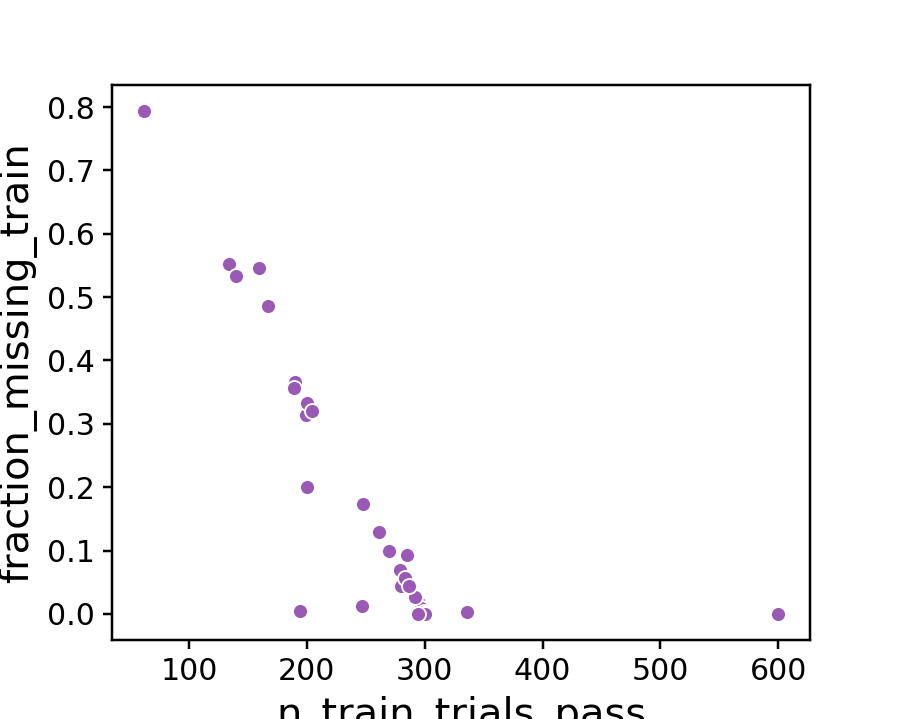

In [39]:
fig, ax = pl.subplots(figsize=(5,4))
sns.scatterplot(x='n_train_trials_pass', y='fraction_missing_train', ax=ax, data=pupil_counts)

In [ ]:
# meandf[meandf['datakey']=='20190512_JC083_fov1']

In [40]:
#### Remove trials with no pupildata
pupildata, MEANS, bad_alignment = dlcutils.add_stimuli_to_pupildf(pupildata, MEANS, SDF, 
                                                                  verbose=False, return_valid_only=True)

In [41]:
remove_too_few=False
min_ncells=5
has_retino=False
threshold_snr=False
threshold_dff=False

if analysis_type in ['single_cells', 'by_fov', 'split_pupil']:
    match_distns = False
match_str = 'matchdistns_' if match_distns else ''
if threshold_dff:
    overlap_str = 'threshdff'
else:
    if has_retino:
        overlap_str = 'retino'
    else:
        overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

NEURALDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                            stack_neuraldf=stack_neuraldf, overlap_thr=overlap_thr, 
                            has_retino=has_retino, threshold_snr=threshold_snr, 
                            remove_too_few=remove_too_few, min_ncells=min_ncells) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)


Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}


In [ ]:
# print(curr_datakey, NEURALDATA['V1'][curr_datakey].shape)

#### Combine into stacked df

In [ ]:
# NDATA = aggr.neuraldf_dict_to_dataframe(NEURALDATA, response_type='response')
    
# counts = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
# counts.head()

# fig, ax = pl.subplots(figsize=(4,3))
# # sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
# #            hue='datakey', palette='colorblind')
# # ax.legend_.remove()
# sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas)
# sns.stripplot(x='visual_area', y='cell', data=counts, ax=ax,
#             order=visual_areas, color='k', s=10)
# ax.set_title("N cells, by FOV (test=%s, thr=%.2f)" \
#              % (responsive_test, responsive_thr), loc='left')


## Test classifier w/ example FOV

In [ ]:
# def balance_samples_by_config(df1, df2, config_label='config'):
#     '''
#     Given 2 dataframes with config labels on each trial, match reps per config.
#     config_label: if 'config', matches across all configs found (config001, config002, etc.)
#     For ex., can also use "morphlevel" to just match counts of morphlevel (ignoring unique size, etc.)
#     '''
#     assert config_label in df1.columns, "Label <%s> not in df1 columns" % config_label
#     assert config_label in df2.columns, "Label <%s> not in df2 columns" % config_label
    
#     df1_eq = aggr.equal_counts_df(df1)
#     df2_eq = aggr.equal_counts_df(df2)
    
    
#     # Get min N reps per condition
#     min_reps_per = min([df1_eq[config_label].value_counts()[0], df2_eq[config_label].value_counts()[0]])
    
#     # Draw min_reps_per samples without replacement
#     df2_resampled = pd.concat([g.sample(n=min_reps_per, replace=False) for c, g in df2_eq.groupby([config_label])])
#     df1_resampled = pd.concat([g.sample(n=min_reps_per, replace=False) for c, g in df1_eq.groupby([config_label])])

#     return df1_resampled, df2_resampled


In [ ]:
curr_datakey = '20190322_JC073_fov1'
curr_visual_area='Li'

session, animalid, fovn = curr_datakey.split('_')
fovnum = int(fovn[3:])
print(curr_datakey in pupil_counts['datakey'].values)

# ------ STIMULUS INFO -----------------------------------------
sdf = SDF[curr_datakey].copy()
train_configs = dlcutils.get_train_configs(sdf, class_name='morphlevel', class_a=0, class_b=106, 
                                          train_transform_name=None)

In [ ]:
# neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
# n_cells = int(neuraldf.shape[1]-1)
# curr_rois = cells[(cells['datakey']==datakey) & (cells['visual_area']==visual_area)]['cell'].values
# assert n_cells==len(curr_rois)
neuraldf = aggr.get_neuraldf_for_cells_in_area(CELLS, MEANS,
                                           datakey=curr_datakey, visual_area=curr_visual_area)
pupildf = pupildata[curr_datakey].copy()
print("Sz neural: %s, pupil: %s" % (str(neuraldf.shape), str(pupildf.shape)))
# print(pupildf.head())
unique_ntrials_per = neuraldf['config'].value_counts().unique()
print("Found %i reps per cond: %s" % (len(unique_ntrials_per), str(unique_ntrials_per)))

In [ ]:
#### Match trial numbers
neuraldf, pupildf = dlcutils.match_neural_and_pupil_trials(neuraldf, pupildf, equalize_conditions=False)
print("Equalizing reps per condition: %s" % str(neuraldf['config'].value_counts().unique()))

# neuraldf = aggr.zscore_neuraldf(neuraldf)
n_cells, _ = neuraldf.shape
print("... SPLIT_PUPIL | [%s] %s, n=%i cells" % (curr_visual_area, curr_datakey, n_cells))
print("... Sz after equal conds (neural: %s, pupil: %s)" % (str(neuraldf.shape), str(pupildf.shape)))


In [657]:
neuraldf.shape

(280, 6)

In [658]:
# pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=pupil_feature, n_cuts=n_cuts)
# print(pupil_low.shape, pupil_high.shape)

# low_trial_ixs = pupil_low['trial'].unique()
# high_trial_ixs = pupil_high['trial'].unique()
# all_trial_ixs = pupildf['trial'].unique()

In [659]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [660]:
multiple_configs = ['20190314_JC070_fov1', '20190327_JC073_fov1']

equalize_by = 'morph_size' if curr_datakey in multiple_configs else 'config'

pupildf['morph_size'] = ['%s_%s' % (m, s) for m, s in zip(pupildf['morphlevel'], pupildf['size'])]


In [661]:
# match_all_configs=False
# equalize_by='config'

# class_name='morphlevel'
# train_classes = [class_a, class_b]
# print("Class: %s, %s" % (class_name, str(train_classes)))
# train_labels = pupildf[pupildf[class_name].isin(train_classes)][equalize_by].unique()
# common_labels = train_labels if not match_all_configs else None
# print(common_labels)


# low, high = decutils.balance_pupil_split(pupildf, feature_name=pupil_feature, n_cuts=n_cuts, 
#                     match_cond=True, match_cond_name='size', equalize_after_split=True, 
#                     equalize_by=equalize_by, verbose=True, common_labels=common_labels)

# pupildf['morph_size'] = ['%s_%s' % (m, s) for m, s in zip(pupildf['morphlevel'], pupildf['size'])]
# equalize_after_split=True
# verbose=True
# low_ = []
# high_ = []
# for sz, sd in pupildf.groupby(['size']):
#     p_low, p_high = dlcutils.split_pupil_range(sd, feature_name=pupil_feature, n_cuts=n_cuts)
#     print(sz, p_low.shape, p_high.shape)
# #     p_low_eq = aggr.equal_counts_df(p_low)
# #     p_high_eq = aggr.equal_counts_df(p_high)
# #     print(sz, p_low_eq.shape, p_high_eq.shape)
#     if equalize_after_split:
#         p_low_eq, p_high_eq = decutils.balance_samples_by_config(p_low, p_high, config_label='morph_size')
#         if verbose:
#             print("... sz %i, pre/post balance. Low: %i/%i | High: %i/%i" \
#               % (sz, p_low.shape[0], p_low_eq.shape[0], p_high.shape[0], p_high_eq.shape[0]))
#         low_.append(p_low_eq)
#         high_.append(p_high_eq)
#     else:
#         low_.append(p_low)
#         high_.append(p_high)
# high = pd.concat(high_)
# low = pd.concat(low_)
# print(high.shape, low.shape)

In [662]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [663]:
# sz=20
# sd = pupildf[pupildf['size']==sz].copy()

# p_low, p_high = dlcutils.split_pupil_range(sd, feature_name=pupil_feature, n_cuts=n_cuts)
# print(sz, p_low.shape, p_high.shape)

# p_low_eq, p_high_eq = decutils.balance_samples_by_config(p_low, p_high, 
#                                     config_label=equalize_by, common_labels=common_labels)
# print("... sz %i, pre/post balance -%s- Low: %i/%i | High: %i/%i" \
#                % (sz, equalize_by, p_low.shape[0], p_low_eq.shape[0], p_high.shape[0], p_high_eq.shape[0]))

In [664]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [665]:
sdf['config'] = sdf.index.tolist()
sdf.head()

class_name='morphlevel'
train_classes = [class_a, class_b]
print("Class: %s, %s" % (class_name, str(train_classes)))
train_labels = sdf[sdf[class_name].isin(train_classes)][equalize_by].unique()
common_labels = train_labels if not match_all_configs else None
print(common_labels)


equalize_by='config'
assert 'size' in pupildf.columns, "Size info not included in pupildf."
neuraldf, pupildf = dlcutils.match_neural_and_pupil_trials(neuraldf, pupildf, equalize_conditions=False)

pupil_low, pupil_high = decutils.balance_pupil_split(pupildf, feature_name=pupil_feature, n_cuts=n_cuts,
                                match_cond=True, match_cond_name='size', equalize_after_split=True,
                                equalize_by=equalize_by, common_labels=common_labels, verbose=True)

Class: morphlevel, [0, 106]
['config006' 'config007' 'config008' 'config009' 'config010' 'config046'
 'config047' 'config048' 'config049' 'config050']
... sz 10, pre/post balance. Low: 18/8 | High: 18/9
... sz 20, pre/post balance. Low: 20/7 | High: 20/9
... sz 30, pre/post balance. Low: 20/13 | High: 20/12
... sz 40, pre/post balance. Low: 19/9 | High: 19/9
... sz 50, pre/post balance. Low: 18/7 | High: 18/8


In [678]:
pupil_low[pupil_low[equalize_by].isin(common_labels)]['config'].value_counts().shape

(8,)

In [677]:
pupil_high[pupil_high[equalize_by].isin(common_labels)]['config'].value_counts().shape

(10,)

In [686]:
sz=10.
sd=pupildf[pupildf['size']==sz].copy()

config_label='config'
p_low, p_high = dlcutils.split_pupil_range(sd, feature_name=pupil_feature, n_cuts=n_cuts)
df1=p_low.copy()
df2=p_high.copy()

# Get equal counts for specified labels
df1_eq = aggr.equal_counts_df(df1[df1[config_label].isin(common_labels)], equalize_by=config_label)
df2_eq = aggr.equal_counts_df(df2[df2[config_label].isin(common_labels)], equalize_by=config_label)
# Check that each partition has the same # of labels (i.e., if missing 1 label, will ahve diff #s)
df1_labels = df1_eq[df1_eq[config_label].isin(common_labels)][config_label].unique()
df2_labels = df2_eq[df2_eq[config_label].isin(common_labels)][config_label].unique()
checked_labels = np.intersect1d(df1_labels, df2_labels)


In [688]:
df1_labels, df2_labels

(array(['config046'], dtype=object),
 array(['config046', 'config006'], dtype=object))

In [689]:
sdf[sdf['config'].isin(['config046', 'config006'])]

morphlevel   object  size stimtype  xpos  ypos yrot     config
config006          0  Blob_N1  10.0    image     0     0    0  config006
config046        106  Blob_N2  10.0    image     0     0    0  config046

In [666]:
trainset_size_low = pupil_low[pupil_low[equalize_by].isin(common_labels)].shape[0] if not match_all_configs \
                        else pupil_low.shape[0]
trainset_size_high = pupil_high[pupil_high[equalize_by].isin(common_labels)].shape[0] if not match_all_configs \
                        else pupil_high.shape[0]
assert trainset_size_low==trainset_size_high, \
        "Unequal pupil training trials: low=%i, high=%i" % (trainset_size_low, trainset_size_high)
#print("SPLIT PUPIL: %s (low), %s (high)" % (str(pupil_low.shape), str(pupil_high.shape)))


AssertionError: Unequal pupil training trials: low=10, high=12

In [633]:
low_trial_ixs = sorted(pupil_low['trial'].values)
high_trial_ixs = sorted(pupil_high['trial'].values)
all_trial_ixs = sorted(pupildf['trial'].values)
print(len(low_trial_ixs), len(high_trial_ixs), len(all_trial_ixs))

(348, 345, 1467)


In [634]:
curr_data = neuraldf.loc[high_trial_ixs].copy()
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data.shape

(70, 109)

In [644]:
len(train_configs)

10

In [645]:
curr_data0 = curr_data.copy()
curr_data0['class'] = [sdf['morphlevel'][c] for c in curr_data0['config']]
print(curr_data0['class'].value_counts())
print(curr_data0['config'].value_counts())

 106    35
 92     35
 79     35
 40     35
 27     35
 0      35
-1      35
 14     34
 66     33
 53     33
Name: class, dtype: int64
config009    8
config044    8
config004    8
config019    8
config029    8
config039    8
config049    8
config024    8
config027    7
config010    7
config050    7
config023    7
config007    7
config018    7
config032    7
config048    7
config008    7
config028    7
config025    7
config002    7
config003    7
config005    7
config020    7
config012    7
config013    7
config014    7
config043    7
config045    7
config022    7
config017    7
config033    7
config047    7
config040    7
config037    7
config042    7
config015    7
config035    7
config038    7
config041    6
config001    6
config034    6
config046    6
config026    6
config036    6
config006    6
config031    6
config016    6
config011    6
config021    6
config030    5
Name: config, dtype: int64


In [483]:
#### Make sure train set has equal counts per config
# sample_data0 = aggr.equal_counts_df(sample_data)
# sample_data0['config'].value_counts()

In [549]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [550]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [551]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.pyc'>

In [555]:
n_iterations=5
n_processes=1
test_type=None
n_train_configs=4

# Decoding -----------------------------------------------------
arousal_conds = ['all', 'low', 'high']
arousal_trial_ixs = [all_trial_ixs, low_trial_ixs, high_trial_ixs]
iter_list=[]
for arousal_cond, curr_trial_ixs in zip(arousal_conds, arousal_trial_ixs):
    print(arousal_cond)
    # Get neuraldf for current trials
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    curr_data = aggr.zscore_neuraldf(curr_data)
    
    # Fit.
    start_t = time.time()
    cond_df = decutils.pool_bootstrap(curr_data, sdf, C_value=C_value,
                            n_iterations=n_iterations, n_processes=n_processes, verbose=False,
                            class_a=class_a, class_b=class_b, do_shuffle=True, balance_configs=False,
                            test_type=test_type, n_train_configs=n_train_configs)
    end_t = time.time() - start_t
    print("--> Elapsed time: {0:.2f}sec".format(end_t))
    cond_df['n_trials'] = len(curr_trial_ixs)
    cond_df['arousal'] = arousal_cond
    iter_list.append(cond_df)

print("%i items in split-pupil list" % len(iter_list))
# DATA - get mean across items
iter_results = pd.concat(iter_list, axis=0)

all
Labels: [  0 106]
Groups: [50. 30. 10. 40. 20.]
# Tuning hyper-parameters for accuracy
[None]... n: 8 (1 procs)
Best parameters set found on development set:
{'C': 0.01}
Grid scores on development set (scoring=accuracy):
0.571 (+/-0.101) for {'C': 0.001}
0.592 (+/-0.086) for {'C': 0.01}
0.558 (+/-0.049) for {'C': 0.1}
0.558 (+/-0.093) for {'C': 1}
0.558 (+/-0.072) for {'C': 10}
0.558 (+/-0.072) for {'C': 100}
0.558 (+/-0.072) for {'C': 1000}
... train (C=0.01): 0.63, test: 0.59
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
             precision    recall  f1-score   support

          0       0.57      0.53      0.55        30
        106       0.56      0.60      0.58        30

avg / total       0.57      0.57      0.57        60

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 0.1}
Grid scores on development set (scoring=accuracy):
0.446 (+/-0.086) 

0.567 (+/-0.107) for {'C': 1}
0.567 (+/-0.149) for {'C': 10}
0.552 (+/-0.156) for {'C': 100}
0.552 (+/-0.156) for {'C': 1000}
... train (C=0.10): 0.66, test: 0.58
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
             precision    recall  f1-score   support

          0       0.45      0.56      0.50         9
        106       0.33      0.25      0.29         8

avg / total       0.40      0.41      0.40        17

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 1}
Grid scores on development set (scoring=accuracy):
0.537 (+/-0.152) for {'C': 0.001}
0.567 (+/-0.175) for {'C': 0.01}
0.567 (+/-0.117) for {'C': 0.1}
0.597 (+/-0.152) for {'C': 1}
0.582 (+/-0.172) for {'C': 10}
0.582 (+/-0.172) for {'C': 100}
0.582 (+/-0.172) for {'C': 1000}
... train (C=1.00): 0.68, test: 0.59
Detailed classification report:
The model is trained on the full development set.


# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 0.1}
Grid scores on development set (scoring=accuracy):
0.493 (+/-0.030) for {'C': 0.001}
0.493 (+/-0.030) for {'C': 0.01}
0.552 (+/-0.248) for {'C': 0.1}
0.552 (+/-0.151) for {'C': 1}
0.552 (+/-0.151) for {'C': 10}
0.537 (+/-0.116) for {'C': 100}
0.537 (+/-0.116) for {'C': 1000}
... train (C=0.10): 0.67, test: 0.55
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
             precision    recall  f1-score   support

          0       0.64      0.78      0.70         9
        106       0.67      0.50      0.57         8

avg / total       0.65      0.65      0.64        17

Labels: [  0 106]
Groups: [30. 20. 40. 50. 10.]
# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 0.1}
Grid scores on development set (scoring=accuracy):
0.493 (+/-0.030) for {'C': 0.001}
0.493 (+/-0.

In [556]:
iter_results.groupby(['condition', 'arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition arousal                                                               
data      all       0.2440  0.001483    0.015088     0.009545        0.021768   
          high     22.0600  0.002650    0.060833     0.041939        0.087764   
          low       0.0604  0.000462    0.007362    -0.018581        0.010620   
shuffled  all      20.2402  0.013727    0.005528    -0.005340        0.007975   
          high      0.2602  0.000536    0.011689    -0.025335        0.016864   
          low       4.2004  0.001675    0.013199    -0.009637        0.019042   

                   heldout_test_score   randi  score_time  test_score  \
condition arousal                                                       
data      all                0.570000  3668.8    0.000392    0.596667   
          high               0.564706  4647.2    0.000277    0.641612   
          low                0.447059  5796.4    0.000267    0.539341   
shuffled  all                0.536667  3668.8    0.000421    0.505833   
          high               0.517647  4647.2    0.000263    0.536117   
          low                0.505882  5796.4    0.000267    0.529707   

                   train_score  n_cells  n_trials  n_samples_0  n_samples_106  \
condition arousal                                                               
data      all         0.623750      8.0    1350.0        150.0          150.0   
          high        0.729858      8.0     363.0         42.0           42.0   
          low         0.601370      8.0     364.0         42.0           42.0   
shuffled  all         0.570000      8.0    1350.0        150.0          150.0   
          high        0.642395      8.0     363.0         42.0           42.0   
          low         0.628166      8.0     364.0         42.0           42.0   

                   iteration  
condition arousal             
data      all            2.0  
          high           2.0  
          low            2.0  
shuffled  all            2.0  
          high           2.0  
          low            2.0

<IPython.core.display.Javascript object>


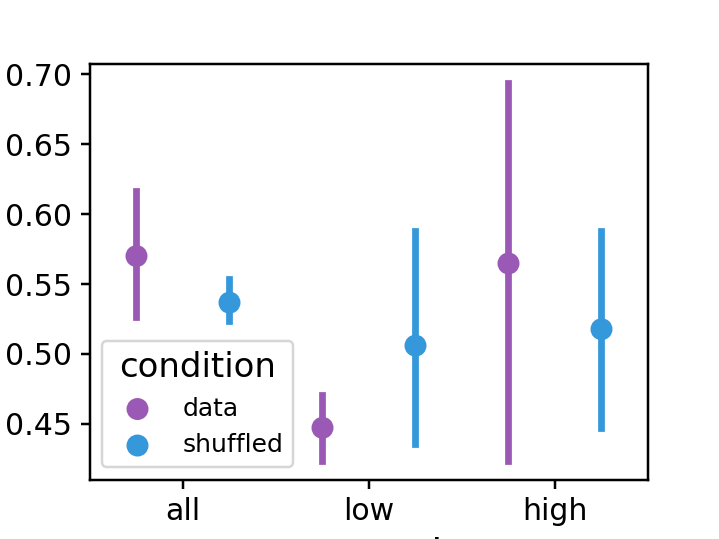

In [557]:
fig, ax = pl.subplots(figsize=(4,3))
sns.pointplot(x='arousal', y='heldout_test_score', hue='condition', data=iter_results, ax=ax,
             join=False, dodge=0.5)

In [146]:
iter_results.groupby(['condition', 'arousal']).mean()

C   fit_time  heldout_MI  heldout_aMI  \
condition arousal                                                 
data      all        0.0100   0.004533    0.113114     0.153722   
          high       0.0280   0.000632    0.073534     0.049913   
          low        0.0244   0.000622    0.055644     0.015698   
shuffled  all      202.2004  15.190389    0.003345    -0.006508   
          high       0.0262   0.000627    0.030357    -0.018318   
          low        0.2026   0.000643    0.021049    -0.025639   

                   heldout_log2MI  heldout_test_score   randi  score_time  \
condition arousal                                                           
data      all            0.163189            0.727273  6598.4    0.001104   
          high           0.106087            0.657143  3502.4    0.000291   
          low            0.080278            0.557143  5090.4    0.000292   
shuffled  all            0.004825            0.527273  6598.4    0.001268   
          high           0.043795            0.457143  3502.4    0.000289   
          low            0.030367            0.457143  5090.4    0.000289   

                   test_score  train_score  n_cells  n_trials  iteration  
condition arousal                                                         
data      all        0.715043     0.846235     87.0    1650.0        2.0  
          high       0.648000     0.951818     87.0     350.0        2.0  
          low        0.590000     0.831818     87.0     350.0        2.0  
shuffled  all        0.510342     0.773856     87.0    1650.0        2.0  
          high       0.513333     0.872292     87.0     350.0        2.0  
          low        0.463333     0.751225     87.0     350.0        2.0

<IPython.core.display.Javascript object>


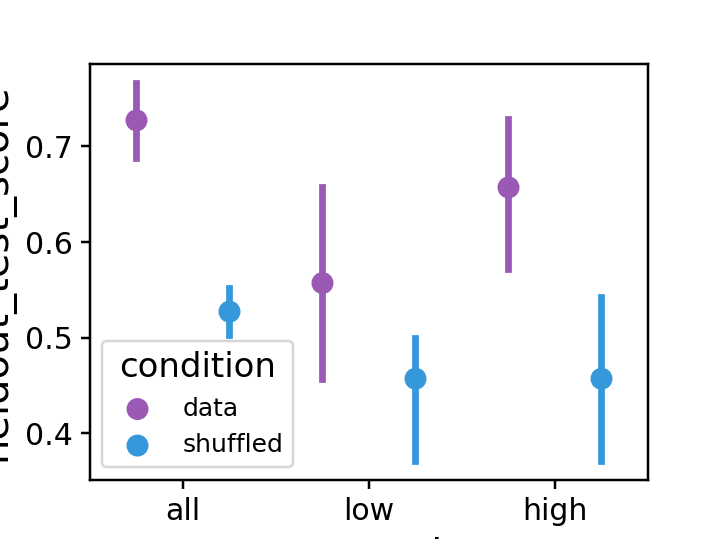

In [148]:
fig, ax = pl.subplots(figsize=(4,3))
sns.pointplot(x='arousal', y='heldout_test_score', hue='condition', data=iter_results, ax=ax,
             join=False, dodge=0.5)

## Test loading for example FOV

In [26]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

In [29]:
overlap_thr=None
C_value=None
trial_epoch='plushalf'

results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch, test_type=None)
results_id

'split_pupil_varea__dff-ROC_noRF__plushalf__tuneC'

In [30]:
_, response_id, tepoch, C_str = results_id.split('__')
# C_str = 'tuneC' if C_value is None else 'C-%.2f' % float(C_value)
result_str = '%s__%s__%s__%s' % (analysis_type, response_id, tepoch, C_str)
result_str

'split_pupil__dff-ROC_noRF__plushalf__tuneC'

In [31]:
# datakey = '20190522_JC084_fov1'
# visual_area = 'V1'

datakey = '20190622_JC085_fov1'
visual_area = 'V1'

session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
fov = 'FOV%i_zoom2p0x' % fovnum
results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, visual_area=visual_area,
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch)

res = dc.load_decode_within_fov(animalid, session, fov, results_id=results_id, traceid=traceid)
res.groupby(['condition', 'arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition arousal                                                               
data      all      0.02458  0.010805    0.083209     0.109045        0.120045   
          high     0.04852  0.000932    0.133231     0.130177        0.192212   
          low      0.03916  0.001227    0.030768     0.002482        0.044389   
shuffled  all      0.16174  0.013093    0.006423    -0.003152        0.009266   
          high     0.01738  0.001072    0.017072    -0.005277        0.024630   
          low      0.01405  0.001080    0.013359    -0.004693        0.019273   

                   heldout_test_score  score_time  test_score  train_score  \
condition arousal                                                            
data      all                0.689333    0.002835    0.698792     0.896635   
          high               0.683333    0.000270    0.675889     0.989405   
          low                0.555385    0.000415    0.597091     0.844729   
shuffled  all                0.502000    0.002381    0.520250     0.817292   
          high               0.496667    0.000381    0.557000     0.698833   
          low                0.521538    0.000394    0.579354     0.719437   

                   n_cells  n_trials  iteration  
condition arousal                                
data      all        196.0     300.0       49.5  
          high       196.0      58.0       49.5  
          low        196.0      64.0       49.5  
shuffled  all        196.0     300.0       49.5  
          high       196.0      58.0       49.5  
          low        196.0      64.0       49.5

In [32]:
traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_blobs*',
                                     'traces', '%s*' % traceid))[0]
curr_dst_dir = os.path.join(traceid_dir, 'decoding')    
results_outfile = os.path.join(curr_dst_dir, '%s.pkl' % results_id)  


os.path.exists(results_outfile)


True

# Unique dsets

In [31]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[POR] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
Dropping 12 dkeys (30 of 42 dkeys unique)


# Aggregate decoding results

In [32]:
# results_id = dc.create_results_id(prefix=analysis_type, test_type=test_type,
#                         visual_area=curr_visual_area, 
#                         response_type=response_type, responsive_test=responsive_test,
#                         trial_epoch=trial_epoch, C_value=C_value, 
#                         has_retino=has_retino,overlap_thr=overlap_thr, 
#                         threshold_dff=threshold_dff)
# print(results_id)
# del results_id

In [74]:
'20190617_JC097_fov1' in MEANS.keys()

True

In [33]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil'

In [34]:
trial_epoch

'plushalf'

In [35]:
arousal_colors = {'all': 'k', 'low': 'c', 'high': 'm'}

In [36]:
incomplete = ['20190315_JC070_fov1', '20190502_JC076_fov1', '20190617_JC097_fov1', '20191018_JC113_fov1']
# ['20190315_JC070_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1']

test_type= None #'morph' #'morph_single'

#responsive_test='ROC'
#responsive_thr=10. if responsive_test=='nstds' else 0.05
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, stimfilter_str, response_str])
print(data_id)

#### Create output dir
if test_type is not None:
    curr_dst_dir = os.path.join(dst_dir, 'generalization', test_type, responsive_test)
else:
    curr_dst_dir = os.path.join(dst_dir, responsive_test)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

metric = 'heldout_test_score'
# -------------------------------------------------------------------------------------
data_id = dc.create_results_id_aggr(prefix=analysis_type, C_value=C_value,
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch, 
                        has_retino=has_retino, threshold_dff=threshold_dff, test_type=test_type)
print(data_id)
# df, missing = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, verbose=False,
#                     responsive_test=responsive_test, responsive_thr=responsive_thr,
#                     response_type=response_type, traceid=traceid, C_value=C_value, 
#                     trial_epoch=trial_epoch, match_distns=match_distns,
#                     overlap_thr=overlap_thr, has_retino=has_retino, 
#                     threshold_dff=threshold_dff, return_missing=True, test_type=test_type)

#### Load results
i_=[]
for (visual_area, datakey), g in CELLS.groupby(['visual_area', 'datakey']):
    if datakey in incomplete:
        print("... need to check eyetracker transfer (skipping %s)" % datakey)
        continue
    session, animalid, fovnum = putils.split_datakey_str(datakey)
    fov='FOV%i_zoom2p0x' % fovnum

    i_df, res_id = dc.load_fov_results(animalid, session, fov, traceid=traceid,
                         visual_area=visual_area, C_value=C_value, response_type=response_type,
                        responsive_test=responsive_test, trial_epoch=trial_epoch,
                        overlap_thr=None, has_retino=False, threshold_dff=False,
                        test_type=test_type, analysis_type=analysis_type)
    if i_df is None:
        print("No results: (%s, %s)" % (visual_area, datakey))
    i_.append(i_df)
    
iterdf = pd.concat(i_, axis=0).reset_index(drop=True)

iterdf = aggr.split_datakey(iterdf)

............................................
Responsive test: ROC (thr=0.05)
............................................
traces001|filter_None_blobsonly|dff_ROC-thr-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC
AGGREGATE: split_pupil___dff-ROC_noRF__plushalf__tuneC
split_pupil___dff-ROC_noRF__plushalf__tuneC
... need to check eyetracker transfer (skipping 20190315_JC070_fov1)
No results: (Li, 20190327_JC073_fov1)
... need to check eyetracker transfer (skipping 20191018_JC113_fov1)
... need to check eyetracker transfer (skipping 20190617_JC097_fov1)


In [37]:
iterdf0 = iterdf.copy()
print(iterdf.shape)
iterdf = iterdf0.loc[iterdf0['n_samples_106'].dropna().index.tolist()]
print(iterdf.shape)

(28200, 22)
(27600, 22)


In [38]:
iterdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                14
Lm                17
V1                15

In [39]:
'20191006_JC110_fov1' in CELLS['datakey'].unique()

True

In [40]:
#iterdf.groupby(['visual_area', 'novel', 'arousal', 'morphlevel']).mean()
iterdf.groupby(['condition', 'visual_area', 'arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  \
condition visual_area arousal                                                 
data      Li          all      12.869946  0.095357    0.041996     0.041372   
                      high      4.650734  0.000665    0.069367     0.028711   
                      low       4.470959  0.000551    0.081770     0.045090   
          Lm          all      13.493821  0.095714    0.051756     0.061955   
                      high      5.378246  0.000706    0.067680     0.042953   
                      low       7.216353  0.001347    0.058345     0.031647   
          V1          all       9.442252  0.034703    0.109973     0.144376   
                      high     18.330262  0.001447    0.109567     0.098115   
                      low      13.185568  0.002088    0.087745     0.063444   
shuffled  Li          all      26.701718  0.202127    0.014141    -0.000224   
                      high      6.719918  0.000514    0.051211     0.000539   
                      low       5.794030  0.000597    0.045719    -0.007189   
          Lm          all      34.331267  0.489025    0.009834     0.000516   
                      high      4.235209  0.000816    0.036119     0.001125   
                      low       3.447968  0.000736    0.037680     0.002342   
          V1          all      19.864624  0.254872    0.011672    -0.000189   
                      high     12.863644  0.001895    0.043168    -0.000555   
                      low      16.495744  0.002849    0.044482     0.000967   

                               heldout_log2MI  heldout_test_score  iteration  \
condition visual_area arousal                                                  
data      Li          all            0.060587            0.589277       49.5   
                      high           0.100075            0.547819       49.5   
                      low            0.117969            0.571126       49.5   
          Lm          all            0.074668            0.620352       49.5   
                      high           0.097642            0.579055       49.5   
                      low            0.084174            0.563670       49.5   
          V1          all            0.158657            0.682627       49.5   
                      high           0.158071            0.638248       49.5   
                      low            0.126590            0.599931       49.5   
shuffled  Li          all            0.020401            0.504659       49.5   
                      high           0.073882            0.498404       49.5   
                      low            0.065958            0.485710       49.5   
          Lm          all            0.014188            0.496248       49.5   
                      high           0.052109            0.493308       49.5   
                      low            0.054360            0.493553       49.5   
          V1          all            0.016839            0.497974       49.5   
                      high           0.062279            0.488527       49.5   
                      low            0.064174            0.497913       49.5   

                                 n_cells  n_samples_0  n_samples_106  \
condition visual_area arousal                                          
data      Li          all      34.285714   108.857143     108.357143   
                      high     34.285714    28.500000      28.500000   
                      low      34.285714    28.500000      28.500000   
          Lm          all      66.294118   144.117647     144.117647   
                      high     66.294118    36.764706      36.764706   
                      low      66.294118    36.764706      36.764706   
          V1          all      71.600000   122.666667     122.666667   
                      high     71.600000    32.200000      32.200000   
                      low      71.600000    32.200000      32.200000   
shuffled  Li          all      34.285714   108.857143     108.357

<IPython.core.display.Javascript object>


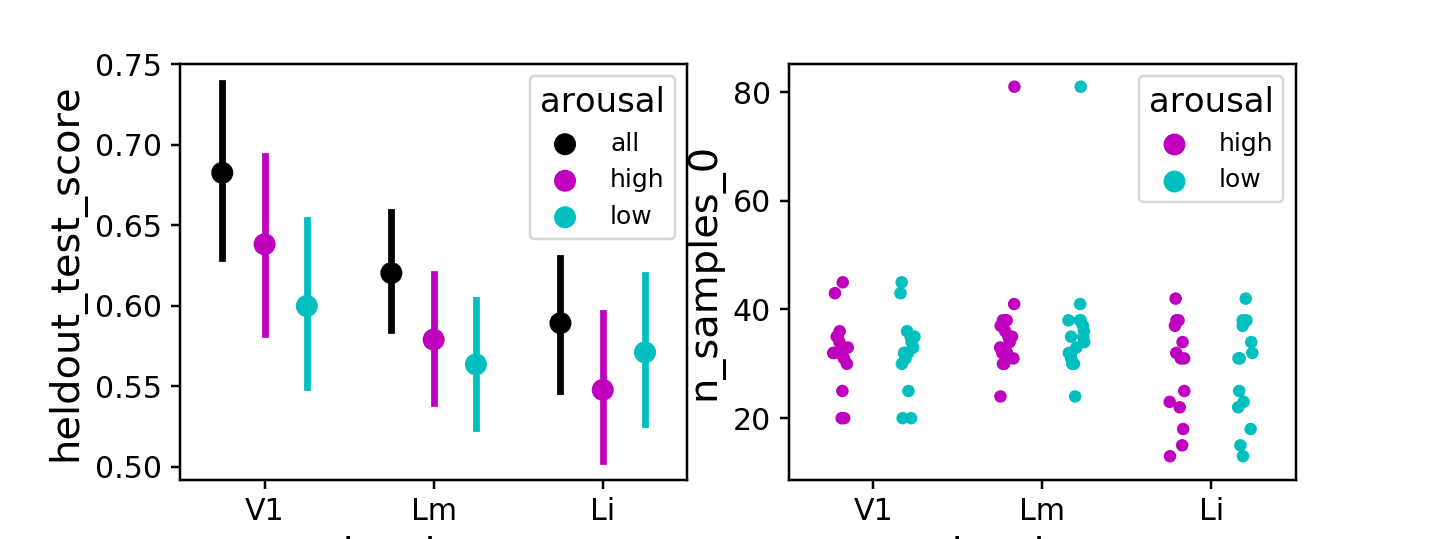

In [41]:
meandf = iterdf.groupby(['datakey', 'condition', 'visual_area', 'arousal']).mean().reset_index()
min_nsamples=0.
plotd = meandf[meandf['n_samples_0']>=min_nsamples].copy()

fig, axn = pl.subplots(1, 2, figsize=(8,3))
ax=axn[0]
sns.pointplot(x='visual_area', y='heldout_test_score', hue='arousal', ax=ax,
             data=plotd[plotd.condition=='data'], dodge=0.5, join=False,
             palette=arousal_colors, order=visual_areas)
ax=axn[1]
sns.stripplot(x='visual_area', y='n_samples_0', hue='arousal', ax=ax,
             data=plotd[(plotd.condition=='data') & (plotd['arousal']!='all')], dodge=True, 
             palette=arousal_colors, order=visual_areas)

In [209]:
meandf[meandf['datakey']=='20190522_JC084_fov1']
meandf[meandf['datakey']=='20190316_JC070_fov1']

datakey condition visual_area arousal         C  fit_time  \
12  20190316_JC070_fov1      data          Li     all   0.08830  0.000860   
13  20190316_JC070_fov1      data          Li    high  31.30804  0.003395   
14  20190316_JC070_fov1      data          Li     low   1.80433  0.000512   
15  20190316_JC070_fov1  shuffled          Li     all  13.31290  0.008403   
16  20190316_JC070_fov1  shuffled          Li    high   4.21363  0.000858   
17  20190316_JC070_fov1  shuffled          Li     low  12.17413  0.002253   

    heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  iteration  \
12    0.017223     0.012643        0.024847            0.570167       49.5   
13    0.055245     0.035916        0.079702            0.597647       49.5   
14    0.015455     0.004673        0.022297            0.454118       49.5   
15    0.009389     0.001132        0.013546            0.512667       49.5   
16    0.017740    -0.006998        0.025594            0.484706       49.5   
17    0.017205    -0.001910        0.024821            0.452941       49.5   

    n_cells  n_samples_0  n_samples_106  n_trials    randi  score_time  \
12      7.0        150.0          150.0    1350.0  5182.73    0.000257   
13      7.0         42.0           42.0     363.0  4911.10    0.000175   
14      7.0         42.0           42.0     364.0  4959.87    0.000164   
15      7.0        150.0          150.0    1350.0  5182.73    0.000271   
16      7.0         42.0           42.0     363.0  4911.10    0.000167   
17      7.0         42.0           42.0     364.0  4959.87    0.000164   

    test_score  train_score  
12    0.572750     0.609167  
13    0.624780     0.724751  
14    0.512907     0.565535  
15    0.508792     0.574052  
16    0.551269     0.633700  
17    0.527099     0.593885

In [42]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC'

<IPython.core.display.Javascript object>


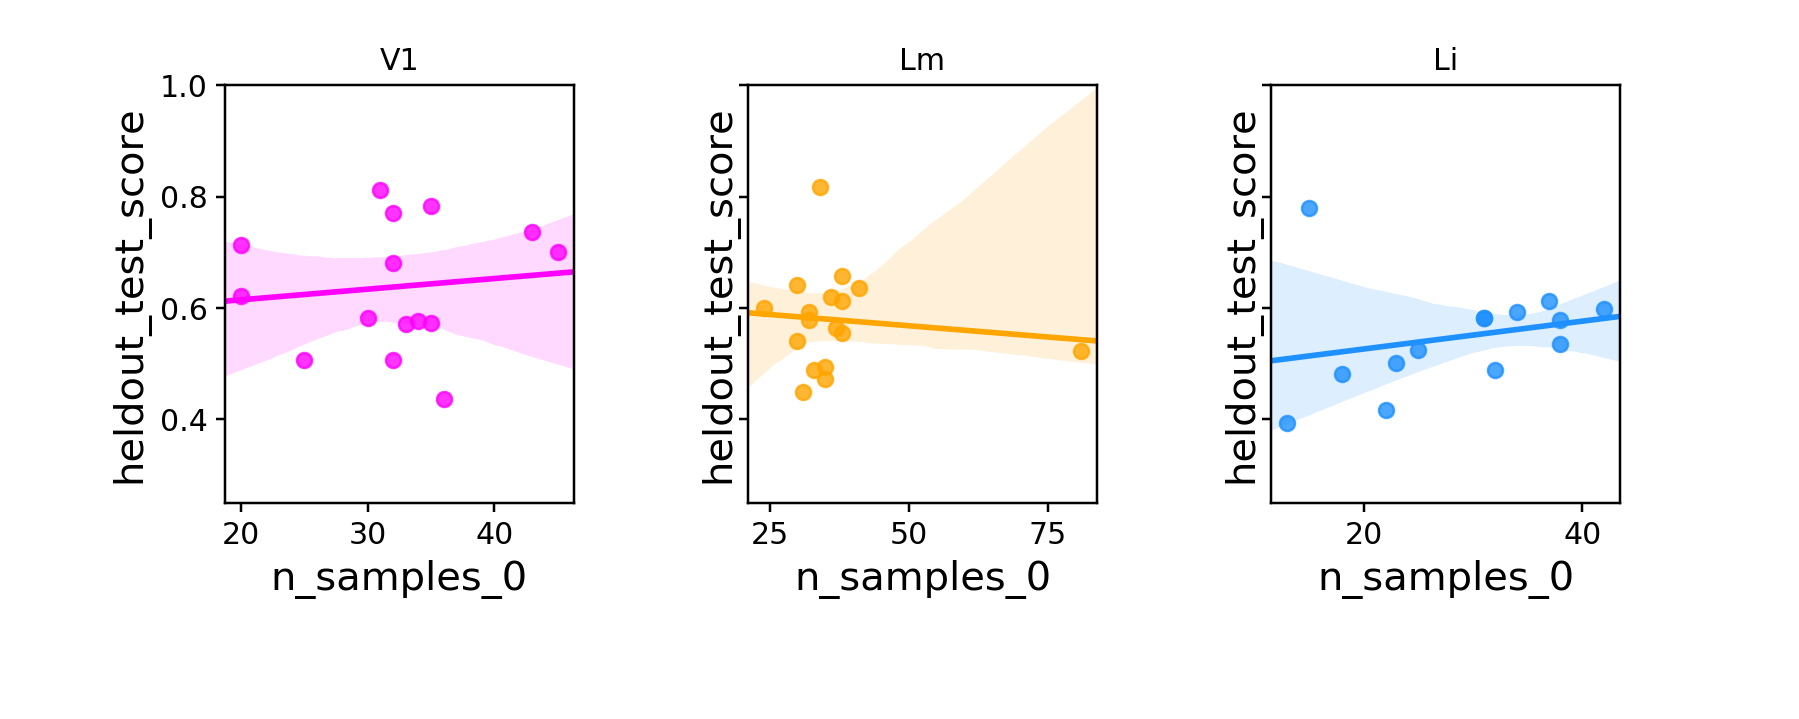

In [43]:
fig, axn = pl.subplots(1,3, figsize=(10, 4), sharex=False, sharey=True)

plotd = meandf[(meandf['n_samples_0']>=0) & (meandf['condition']=='data')].copy()


for visual_area, d_ in plotd[plotd.arousal=='high'].groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax=axn[ai]
    sns.regplot(x='n_samples_0', y='heldout_test_score',
            color=area_colors[visual_area], data=d_, ax=ax)
    ax.set_ylim([0.25, 1])
    ax.set_title(visual_area)
    
    #ax.scatter(d_['n_samples_0'], d_['heldout_test_score'], color=area_colors[visual_area])
pl.subplots_adjust(bottom=0.3, wspace=0.5)

In [44]:
min_frac=0.50
dsets_pass_pupil_trials = pupil_counts[pupil_counts['fraction_missing_train']<min_frac]['datakey']
print(len(dsets_pass_pupil_trials))

36


<IPython.core.display.Javascript object>


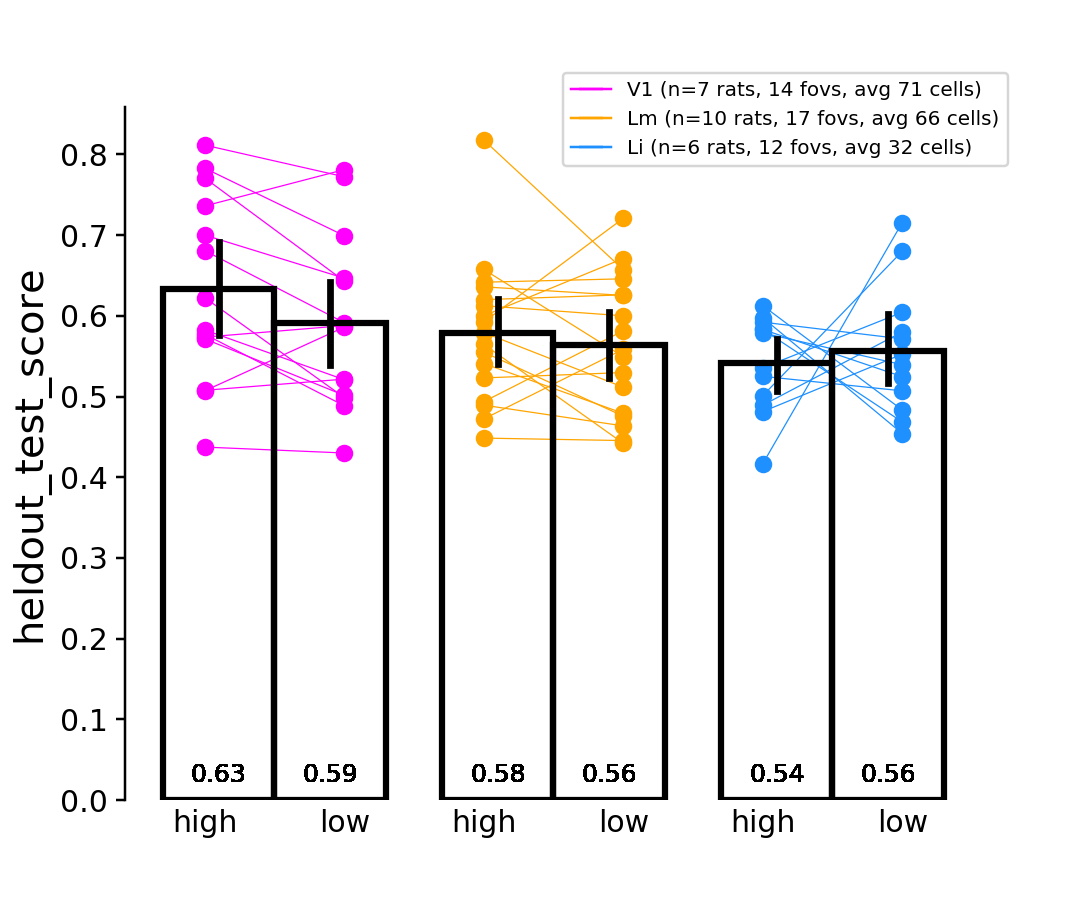

(t-stat:2.52, p=0.03)
(t-stat:0.80, p=0.44)
(t-stat:-0.40, p=0.69)


Text(0.5,0,u'')

In [45]:
c1='high'
c2='low'
compare_var='arousal'

plotd = meandf[(meandf.condition=='data') & (meandf['arousal']!='all') & (meandf['n_samples_0']>=0)
              & (meandf.datakey.isin(dsets_pass_pupil_trials))]

fig, ax = pl.subplots(figsize=(6,5)) #, dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotd, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(.5, 0.9))
ax.set_xlabel('')

In [46]:
# Add some fixes for older runs
# iterdf['novel'] = iterdf['train_transform'] != iterdf['test_transform']
# if all([np.isnan(i) for i in iterdf[iterdf.condition=='shuffled']['novel'].values]):   
#     iterdf['novel'].loc[iterdf.condition=='shuffled'] = False

## Add count info to meandf

In [47]:
pupil_counts.index = pupil_counts['datakey']

#### Average over iterations
visual_areas = ['V1', 'Lm', 'Li']
group_cols = ['visual_area', 'datakey', 'condition', 'arousal']
if test_type is not None:
    group_cols.extend(['train_transform', 'test_transform', 'novel'])
    
if test_type is not None and 'morph' in test_type:
    group_cols.extend(['morphlevel'])
    
meandf = iterdf.groupby(group_cols).mean().reset_index()
meandf = meandf[meandf.visual_area.isin(visual_areas)]

# Addd pupil count data
meandf['fraction_missing_train'] = [pupil_counts.loc[dk]['fraction_missing_train'] for dk in meandf['datakey']]
meandf['fraction_missing_total'] = [pupil_counts.loc[dk]['fraction_missing_total'] for dk in meandf['datakey']]

meandf['n_missing_train'] = [pupil_counts.loc[dk]['n_train_trials_dropped'] for dk in meandf['datakey']]
meandf['n_pass_train'] = [pupil_counts.loc[dk]['n_train_trials_pass'] for dk in meandf['datakey']]
meandf['feature_sample_ratio'] = meandf['n_cells']/meandf['n_pass_train']

In [48]:
# # Calcualte change over shuffled
# meandf['fold_over_shuffle'] = 0.0
# for (v, dk, a, train), g in meandf.groupby(['visual_area', 'datakey', 'arousal', 'train_transform']):
#     for test, gg in g.groupby(['test_transform']):
#         val = float(gg[gg.condition=='data']['heldout_test_score'])
#         shuf = float(g[g.condition=='shuffled']['heldout_test_score'])
#         meandf['fold_over_shuffle'][gg.index] = (val-shuf)/shuf

# meandf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

In [49]:
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC


In [50]:
arousal_colors={'all': 'k', 'low': 'c', 'high': 'm'}

# Exclude garbage results

In [51]:
# def plot_individual_shuffle_distn(df, va, traindf, metric='heldout_test_score'):

#     d_ = traindf[(traindf.visual_area==va) & (traindf.datakey==dk) ].copy()


#     if 'train_transform' in d_.columns:
#         fig, axn = pl.subplots(1, 5, figsize=(10,4), sharex=True, sharey=True)

#         for ai, (transf, g) in enumerate(d_.groupby(['train_transform'])):
#             ax = axn[ai]
#             mean_score = g[g['condition']=='data'][metric].mean()
#             percentile = np.mean(mean_score < g[g['condition']=='shuffled'][metric])
#             ax.set_title('%s: \navg.%.2f (p=%.2f)' % (str(transf), mean_score, percentile), loc='left', fontsize=8)
#             sns.distplot(g[g['condition']=='data'][metric], color='m', ax=ax)
#             sns.distplot(g[g['condition']=='shuffled'][metric], color='k', ax=ax)
#             ax.set_xlabel('')
#         fig.text(0.5, 0.05, metric, ha='center', fontsize=12)
#         fig.text(0.05, 0.95, '%s (%s)' % (dk, va), fontsize=16)
#     else:
#         fig, ax = pl.subplots(1, 1, figsize=(5,4), sharex=True, sharey=True)

#         mean_score = d_[d_['condition']=='data'][metric].mean()
#         percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
#         ax.set_title('avg.%.2f (p=%.2f)' % ( mean_score, percentile), loc='left', fontsize=8)
#         sns.distplot(d_[d_['condition']=='data'][metric], color='m', ax=ax)
#         sns.distplot(d_[d_['condition']=='shuffled'][metric], color='k', ax=ax)
#         ax.set_xlabel('')
#         fig.text(0.5, 0.05, metric, ha='center', fontsize=12)
#         fig.text(0.05, 0.95, '%s (%s)' % (dk, va), fontsize=16)

#     pl.subplots_adjust(bottom=0.2, left=0.1, right=0.95, wspace=0.5, top=0.8)
#     return fig

In [52]:
if 'train_transform' in iterdf.columns:
    traindf = iterdf[(iterdf.train_transform==iterdf.test_transform) & (iterdf.arousal=='all')]\
                .dropna().drop_duplicates()
    d_ = traindf[(traindf.visual_area=='V1') & (traindf.datakey=='20190616_JC097_fov1')].copy()
else:
    traindf = iterdf[(iterdf.arousal=='all')].dropna().drop_duplicates()

In [53]:
metric = 'heldout_test_score'
# all_df = iterdf[iterdf.arousal=='all'].copy()
percentiles = decutils.get_percentile_shuffled(traindf, metric=metric)
percentiles.shape

(46, 16)

In [54]:
# traindf[traindf.datakey=='20190522_JC084_fov1']

In [42]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [43]:
# dk = '20190316_JC070_fov1'
# va = 'Li'
dk = '20190316_JC070_fov1'
va = 'Li'
fig = decutils.plot_individual_shuffle_distn(dk, va, traindf, metric='heldout_test_score')

figname = '%s_%s_example_shuffled_v_true_distn' % (datakey, visual_area)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

NameError: name 'traindf' is not defined

In [74]:
# d_ = all_df[(all_df.visual_area=='Li') & (all_df.datakey=='20191018_JC113_fov1')].copy()
# mean_score = d_[d_['condition']=='data'][metric].mean()
# percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
# print(mean_score, percentile)

# fig, ax = pl.subplots(figsize=(4,3))
# sns.distplot(d_[d_.condition=='data'][metric], color='m', ax=ax)
# sns.distplot(d_[d_.condition=='shuffled'][metric], color='k', ax=ax)
# ax.axvline(x=0.5)

In [59]:
print("Counts, pre-filter:")
print(traindf[['visual_area', 'datakey']].drop_duplicates()\
      .groupby(['visual_area'])['datakey'].count().reset_index()) 

Counts, pre-filter:
  visual_area  datakey
0          Li       14
1          Lm       17
2          V1       15


In [79]:
pass_thr=0.1
# Get datasets in each area where mean score is > shuffled distN

# 1. Get percentiles (best, if more than 1 classifier trained) and find dsets that pass
best_percentile = percentiles.groupby(['visual_area', 'datakey', 'n_trials'])['percentile'].min().reset_index()
pass_shuff = best_percentile[best_percentile['percentile']<=pass_thr][['visual_area', 'datakey', 'n_trials']]
pass_shuffle_list = [(v, d) for (v, d),g in pass_shuff.groupby(['visual_area', 'datakey'])]
whos_missing0 = [(v, k) for (v, k), g in meandf.groupby(['visual_area', 'datakey']) \
                if (v, k) not in pass_shuffle_list]

# Print summary:
print("Percentile %.2f of shuffled:" % pass_thr)
print(pass_shuff.groupby(['visual_area'])['datakey'].count().reset_index()) 

print("%i dsets do not pass shuffle test (p=%.2f)" % (len(whos_missing0), pass_thr))
for w in whos_missing0:
    print w
# 2. Get meandf for dsets that pass shuffled distribution 
# AND, also are missing less than some min. frac due to pupil tracking
# TODO:  How to pick this threshold?
min_frac = .25
min_ncells = 10
filter_str = 'aboveshuffle%.2f_missing%.2f_mincells%i' % (pass_thr, min_frac, min_ncells)

passdf = pd.concat([meandf[(meandf.visual_area==v) & (meandf.datakey==dk)
                         & (meandf['fraction_missing_train']<min_frac)
                         & (meandf['n_cells']>=min_ncells)] \
                       for (v, dk), g in pass_shuff.groupby(['visual_area', 'datakey'])])
final_pass_list = [(v, d) for (v, d), g in passdf.groupby(['visual_area', 'datakey'])]

print("Missing a min frac %.2f due to pupil:" % min_frac)
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

#### 3. and Number of pupil trials missing is below some threshold
#min_ntrials=300 #500 #1000
#pass_acc = passd.copy() #[passd.n_trials>=min_ntrials]

arousaldf = passdf[passdf['arousal'].isin(['high', 'low'])].copy()

whos_missing = [(v, k) for (v, k), g in pass_shuff.groupby(['visual_area', 'datakey']) \
                if (v, k) not in final_pass_list]
print("Booting %i dsets:" % len(whos_missing))
for w in whos_missing:
    print w

Percentile 0.10 of shuffled:
  visual_area  datakey
0          Li        7
1          Lm       13
2          V1       12
14 dsets do not pass shuffle test (p=0.10)
('Li', '20190314_JC070_fov1')
('Li', '20190316_JC070_fov1')
('Li', '20190320_JC067_fov1')
('Li', '20190321_JC070_fov1')
('Li', '20190422_JC076_fov1')
('Li', '20190606_JC091_fov1')
('Li', '20190612_JC099_fov1')
('Lm', '20190306_JC061_fov3')
('Lm', '20190422_JC076_fov1')
('Lm', '20190618_JC097_fov1')
('Lm', '20191111_JC120_fov1')
('V1', '20190420_JC076_fov1')
('V1', '20190512_JC083_fov1')
('V1', '20190517_JC083_fov1')
Missing a min frac 0.25 due to pupil:
             datakey
visual_area         
Li                 4
Lm                11
V1                 9
Booting 8 dsets:
('Li', '20190602_JC091_fov1')
('Li', '20190607_JC091_fov1')
('Li', '20190617_JC099_fov1')
('Lm', '20190327_JC073_fov1')
('Lm', '20190506_JC080_fov1')
('V1', '20190501_JC076_fov1')
('V1', '20190510_JC083_fov1')
('V1', '20190622_JC085_fov1')


In [80]:
filter_str

'aboveshuffle0.10_missing0.25_mincells10'

In [61]:
pupil_counts.sort_values(by='fraction_missing_train', ascending=False)

datakey  n_trials_total  n_trials_dropped  \
datakey                                                                      
20190319_JC067_fov1  20190319_JC067_fov1            1350              1070   
20190602_JC091_fov1  20190602_JC091_fov1            1499               814   
20190510_JC083_fov1  20190510_JC083_fov1            1750               959   
20190320_JC067_fov1  20190320_JC067_fov1            1350               695   
20190606_JC091_fov1  20190606_JC091_fov1            1625               823   
20190622_JC085_fov1  20190622_JC085_fov1            1500               585   
20190617_JC097_fov1  20190617_JC097_fov1            1475               526   
20190501_JC076_fov1  20190501_JC076_fov1            1500               501   
20190607_JC091_fov1  20190607_JC091_fov1            1500               458   
20190506_JC080_fov1  20190506_JC080_fov1            1450               451   
20190321_JC070_fov1  20190321_JC070_fov1            1125               226   
20190420_JC076_fov1  20190420_JC076_fov1            1500               243   
20190314_JC070_fov1  20190314_JC070_fov1            1350               174   
20190306_JC061_fov3  20190306_JC061_fov3            1350               147   
20190512_JC083_fov1  20190512_JC083_fov1            1575               141   
20190613_JC097_fov1  20190613_JC097_fov1            1500               126   
20190609_JC099_fov1  20190609_JC099_fov1            1500                77   
20190508_JC083_fov1  20190508_JC083_fov1            1465                46   
20190627_JC091_fov1  20190627_JC091_fov1            1500                46   
20190522_JC084_fov1  20190522_JC084_fov1            1500                33   
20190322_JC073_fov1  20190322_JC073_fov1            1350                72   
20190614_JC091_fov1  20190614_JC091_fov1            1500                28   
20190517_JC083_fov1  20190517_JC083_fov1            1250                12   
20190507_JC083_fov1  20190507_JC083_fov1            1500                17   
20191111_JC120_fov1  20191111_JC120_fov1            1500                11   
20190603_JC080_fov1  20190603_JC080_fov1            1500                14   
20190617_JC099_fov1  20190617_JC099_fov1             973                 3   
20190618_JC097_fov1  20190618_JC097_fov1            1500                16   
20190511_JC083_fov1  20190511_JC083_fov1            1500                 7   
20191006_JC110_fov1  20191006_JC110_fov1            1675                 1   
20190525_JC084_fov1  20190525_JC084_fov1            1500                 0   
20190504_JC078_fov1  20190504_JC078_fov1            1500                 1   
20190430_JC078_fov1  20190430_JC078_fov1            1475                 1   
20190509_JC078_fov1  20190509_JC078_fov1            1500                 1   
20190316_JC070_fov1  20190316_JC070_fov1            1350                 0   
20190422_JC076_fov1  20190422_JC076_fov1            1500                 5   
20190612_JC099_fov1  20190612_JC099_fov1            1500                 1   
20190616_JC097_fov1  20190616_JC097_fov1            1500                 4   
20190327_JC073_fov1  20190327_JC073_fov1            1500                 1   
20190513_JC078_fov1  20190513_JC078_fov1            1475                 0   

                     n_train_trials  n_train_trials_dropped  \
datakey                                                       
20190319_JC067_fov1             300                     238   
20190602_JC091_fov1             299                     165   
20190510_JC083_fov1             350                     191   
20190320_JC067_fov1             300                     160   
20190606_JC091_fov1             325                     158   
20190622_JC085_fov1             300                     110   
20190617_JC097_fov1             294                     105   
20190501_JC076_fov1             300                     100   
20190607_JC091_fov1             300                      96   
20190506_JC080_fov1             290                      91   


<IPython.core.display.Javascript object>


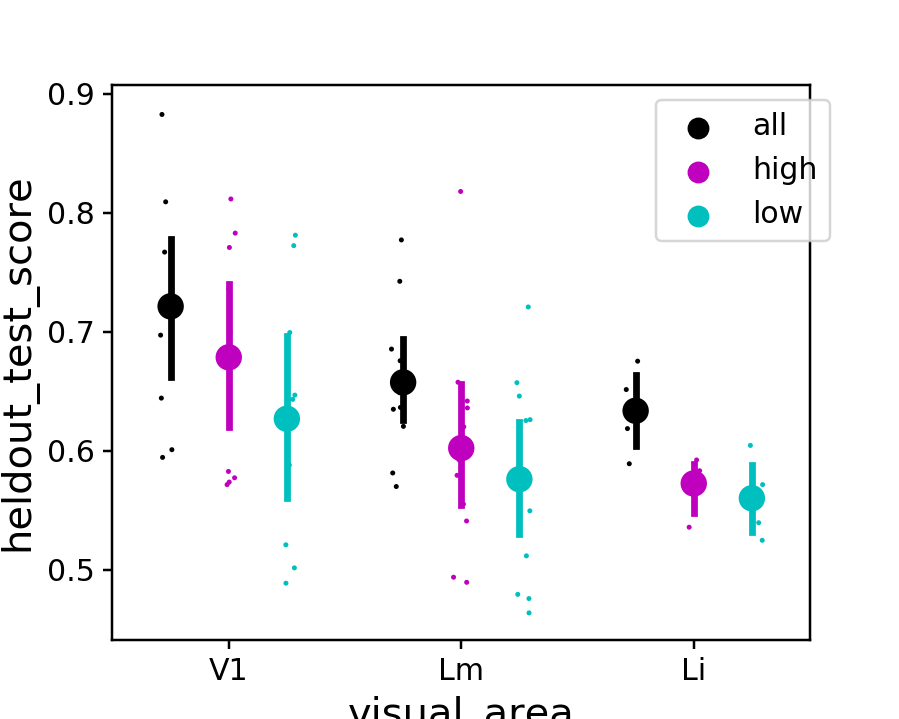

In [81]:
# metric = 'fold_over_shuffle'
metric = 'heldout_test_score'
plotdf = passdf[(passdf.condition=='data') & (passdf.n_cells>=0)].copy()
arousal_colors = {'all': 'k', 'low': 'c', 'high': 'm'}
fig, ax = pl.subplots(figsize=(5,4))
sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
             hue='arousal', dodge=True, order=visual_areas, palette=arousal_colors, size=2)
sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
             hue='arousal', dodge=.5, order=visual_areas, palette=arousal_colors, join=False, scale=1.2)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1,1), loc='upper right')

In [756]:
passdf.head()

visual_area              datakey condition arousal         C  fit_time  \
24          Li  20190322_JC073_fov1      data     all  21.63790  0.301742   
25          Li  20190322_JC073_fov1      data    high   0.42319  0.000437   
26          Li  20190322_JC073_fov1      data     low   0.21592  0.000504   
27          Li  20190322_JC073_fov1  shuffled     all  36.09640  0.602046   
28          Li  20190322_JC073_fov1  shuffled    high   0.83179  0.000366   

    heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
24    0.053026     0.064771        0.076501            0.647627   
25    0.044453    -0.008985        0.064133            0.565000   
26    0.048363    -0.002089        0.069773            0.534167   
27    0.006761    -0.000486        0.009754            0.515254   
28    0.058715     0.021164        0.084707            0.509167   

            ...           n_trials    randi  score_time  test_score  \
24          ...             1278.0  5020.74    0.000428    0.651233   
25          ...              261.0  4499.34    0.000243    0.600400   
26          ...              261.0  5260.34    0.000224    0.598150   
27          ...             1278.0  5020.74    0.000474    0.536831   
28          ...              261.0  4499.34    0.000161    0.560650   

    train_score  fraction_missing_train  fraction_missing_total  \
24     0.761879                0.026667                0.053333   
25     0.925594                0.026667                0.053333   
26     0.816816                0.026667                0.053333   
27     0.661106                0.026667                0.053333   
28     0.849231                0.026667                0.053333   

    n_missing_train  n_pass_train  feature_sample_ratio  
24                8           292              0.130137  
25                8           292              0.130137  
26                8           292              0.130137  
27                8           292              0.130137  
28                8           292              0.130137  

[5 rows x 24 columns]

# Drop repeats

In [82]:
metric = 'heldout_test_score'

# Drop repeat FOVs
all_curr_dsets = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
           for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
            .groupby(['visual_area', 'datakey']).count().reset_index()
all_curr_dsets = putils.split_datakey(all_curr_dsets)
curr_dsets = aggr.select_best_fovs(all_curr_dsets)

excl_dsets = [] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']

passdf_drop = pd.concat([passdf[(passdf.visual_area==v) & (passdf.datakey==dk) & ~(passdf.datakey.isin(excl_dsets))] \
                         for (v, dk), g in curr_dsets.groupby(['visual_area', 'datakey'])])
arousaldf_drop = passdf_drop[passdf_drop.arousal.isin(['high', 'low'])].copy()


print("Drop repeats:")
print(passdf_drop[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
#print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

[V1] Animalid does not exist: JC078 
Drop repeats:
             datakey
visual_area         
Li                 4
Lm                 7
V1                 6


In [83]:
drop_repeats = True
dset_str = '_%s_drop_repeats' % filter_str if drop_repeats else '_%s_alldsets' % filter_str
xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()
print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(dset_str)
# passdf[['visual_area','datakey', 'n_cells', 'arousal', 'n_trials', 'fraction_missing']].drop_duplicates()

             datakey
visual_area         
Li                 4
Lm                 7
V1                 6
_aboveshuffle0.10_missing0.25_mincells10_drop_repeats


<IPython.core.display.Javascript object>


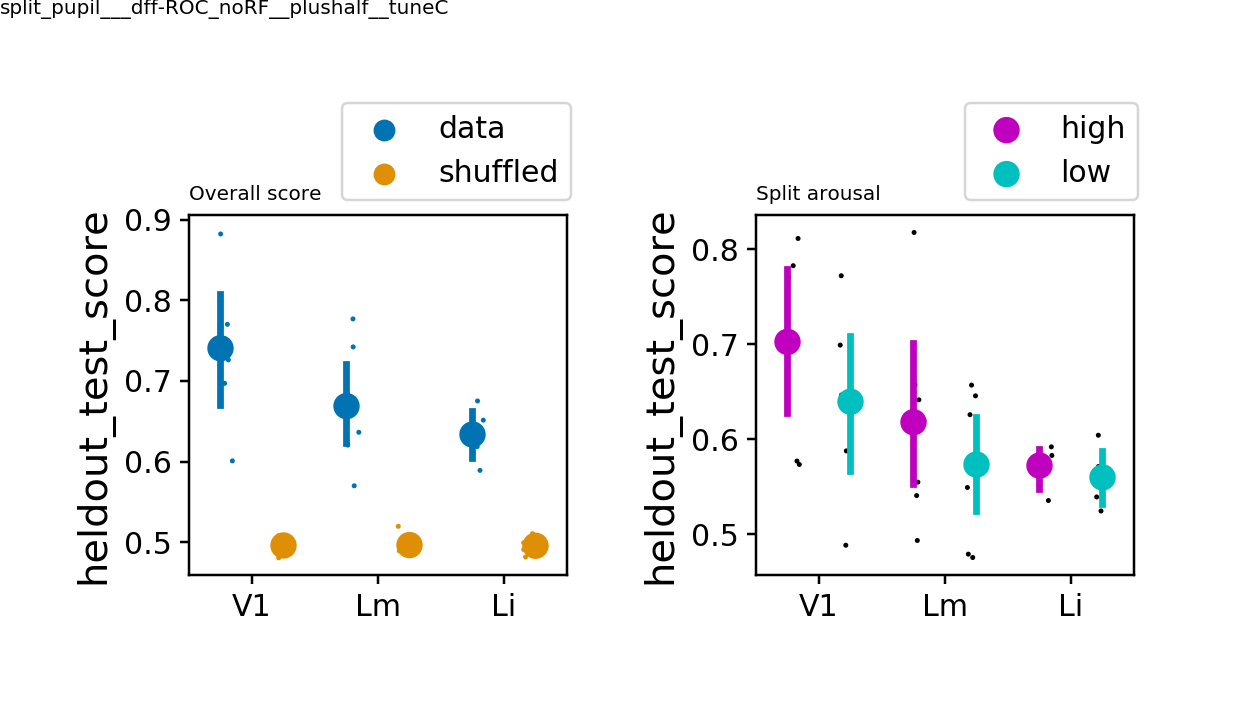

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC', 'compare_shuffle_heldout_test_score___aboveshuffle0.10_missing0.25_mincells10_drop_repeats')


In [84]:
metric = 'heldout_test_score' #'fold_over_shuffle'
fig, axn = pl.subplots(1,2, figsize=(7,4), sharey=False, sharex=True)

ax=axn[0]
ax.set_title('Overall score', loc='left', fontsize=8)
sns.stripplot(x='visual_area', y='heldout_test_score', data=passdf_drop[passdf_drop['arousal']=='all'], ax=ax, 
              hue='condition', dodge=True, palette='colorblind', order=visual_areas, size=2)  

sns.pointplot(x='visual_area', y='heldout_test_score', data=passdf_drop[passdf_drop['arousal']=='all'], ax=ax, 
              hue='condition', dodge=0.5, palette='colorblind', join=False, order=visual_areas, scale=1.2)  
aggr.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1,1))
ax.set_xlabel('')

ax=axn[1]
ax.set_title('Split arousal', loc='left', fontsize=8)
sns.pointplot(x='visual_area', y=metric, data=xdf[xdf['condition']=='data'], ax=ax, 
              hue='arousal', dodge=0.5, palette=('m', 'c'), order=visual_areas, join=False, zorder=-1, scale=1.2)
sns.stripplot(x='visual_area', y=metric, data=xdf[xdf['condition']=='data'], ax=ax, 
              hue='arousal', dodge=True, order=visual_areas, palette=('k', 'k'), marker='o', zorder=0, size=2)
aggr.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1,1))
ax.set_xlabel('')

pl.subplots_adjust(bottom=0.2, left=0.15, wspace=0.5, top=0.7)
putils.label_figure(fig, data_id)

figname = 'compare_shuffle_%s__%s' % (metric, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## Compared paired (high/low)

In [85]:
print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

if test_type is not None:
    bothpass = pd.concat([g for (v, k, t), g in xdf[(xdf.condition=='data') & (xdf.novel)]\
                    .groupby(['visual_area', 'datakey','train_transform']) \
                if (float(g[g.arousal=='high']['fold_over_shuffle'])>0. )
                 & (float(g[g.arousal=='low']['fold_over_shuffle'])>0.)])

    print(bothpass[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                 4
Lm                 7
V1                 6


In [67]:
xdf.columns

Index([u'visual_area', u'datakey', u'condition', u'arousal', u'C', u'fit_time',
       u'heldout_MI', u'heldout_aMI', u'heldout_log2MI', u'heldout_test_score',
       u'iteration', u'n_cells', u'n_samples_0', u'n_samples_106', u'n_trials',
       u'randi', u'score_time', u'test_score', u'train_score',
       u'fraction_missing_train', u'fraction_missing_total',
       u'n_missing_train', u'n_pass_train', u'feature_sample_ratio'],
      dtype='object')

<IPython.core.display.Javascript object>


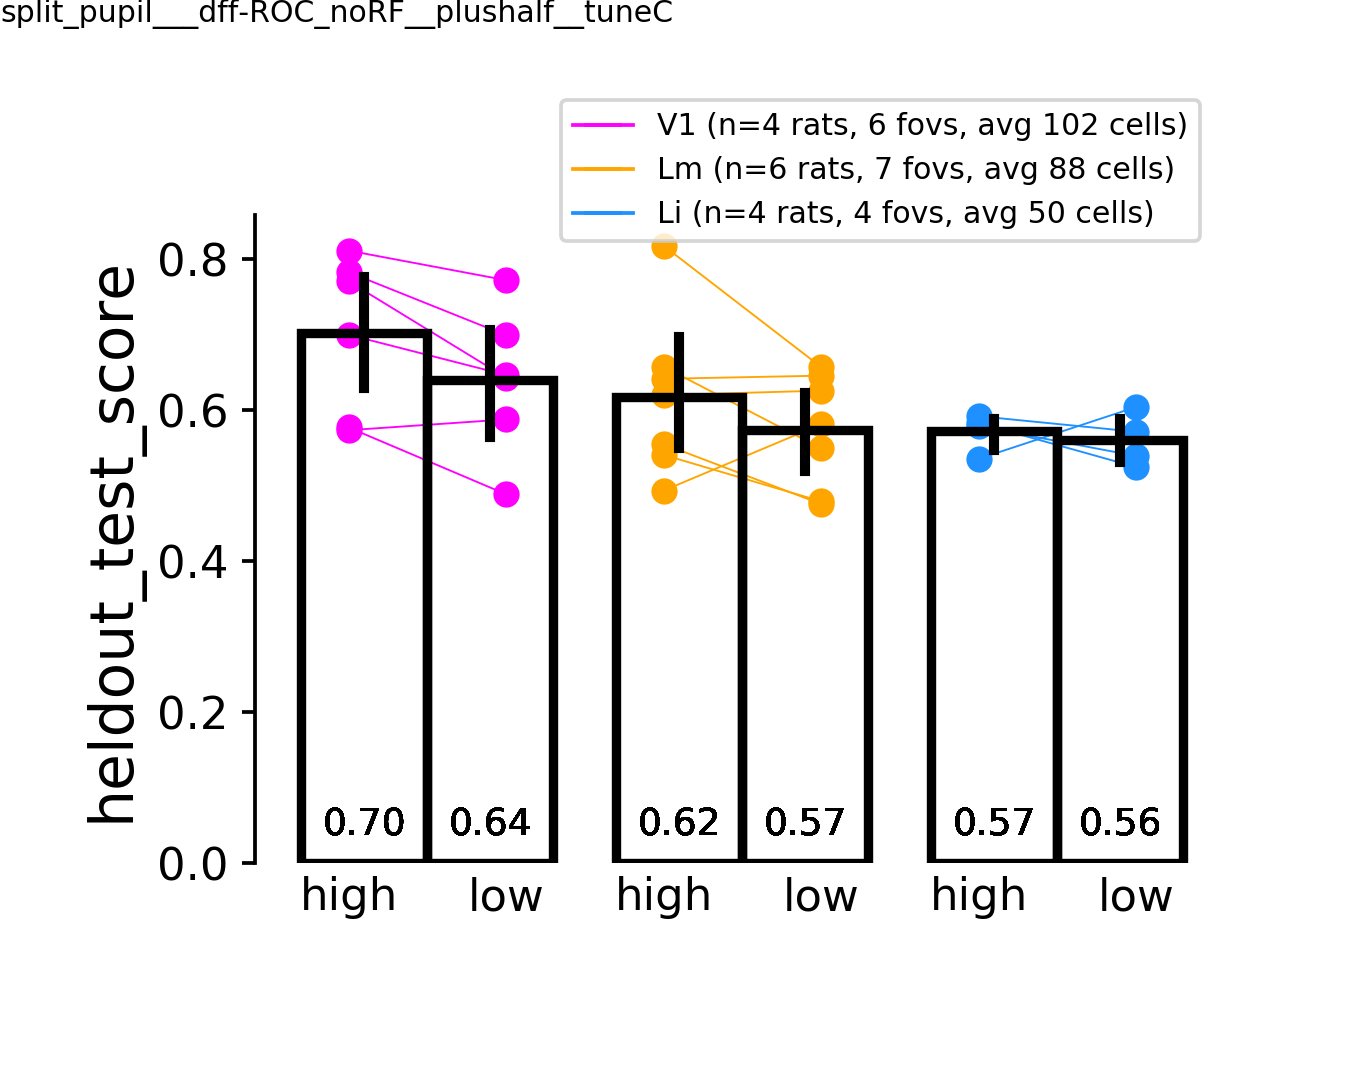

(t-stat:3.16, p=0.02)
(t-stat:1.42, p=0.21)
(t-stat:0.44, p=0.69)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC', 'paired_hi-lo_pass-0.10__heldout_test_score___aboveshuffle0.10_missing0.25_mincells10_drop_repeats')


In [86]:
#min_ncells=5
# min_ncells=10
#min_frac=.3

#xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()

#metric='fold_over_shuffle'
metric='heldout_test_score'
#metric='heldout_aMI'
# plotd = bothpass[(bothpass['condition']=='data')
#                  & (bothpass['n_cells']>=min_ncells) & (bothpass['fraction_missing']<=min_frac)]

if test_type is not None:
    novel_by_fov = xdf[xdf.novel].groupby(['visual_area', 'datakey', 'arousal', 'condition']).mean().reset_index()
    plotd = novel_by_fov[(novel_by_fov['condition']=='data')] #& (xdf['fraction_missing']<=min_frac)]
else:
    plotd = xdf[(xdf['condition']=='data')] #& (xdf['fraction_missing']<=min_frac)]

c1='high'
c2='low'
compare_var='arousal'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotd, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1., 1.2))
ax.set_xlabel('')

pl.subplots_adjust(bottom=0.2, left=0.2, wspace=0.5, top=0.8)
putils.label_figure(fig, data_id)

figname = 'paired_hi-lo_pass-%.2f__%s__%s' % (pass_thr, metric, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [90]:
plotd[plotd.visual_area=='V1'][['datakey', 'arousal', metric, 'n_cells', 'fraction_missing_train']]

datakey arousal  heldout_test_score  n_cells  \
205  20190507_JC083_fov1    high            0.811538     97.0   
206  20190507_JC083_fov1     low            0.772308     97.0   
211  20190508_JC083_fov1    high            0.577143     18.0   
212  20190508_JC083_fov1     low            0.488571     18.0   
247  20190522_JC084_fov1    high            0.782857    107.0   
248  20190522_JC084_fov1     low            0.699286    107.0   
253  20190613_JC097_fov1    high            0.573571    120.0   
254  20190613_JC097_fov1     low            0.587857    120.0   
259  20190616_JC097_fov1    high            0.770769    184.0   
260  20190616_JC097_fov1     low            0.643077    184.0   
271  20191006_JC110_fov1    high            0.700000     86.0   
272  20191006_JC110_fov1     low            0.646667     86.0   

     fraction_missing_train  
205                0.010000  
206                0.010000  
211                0.044369  
212                0.044369  
247                0.030000  
248                0.030000  
253                0.070000  
254                0.070000  
259                0.000000  
260                0.000000  
271                0.002967  
272                0.002967

In [91]:
meandf[meandf.datakey=='20190322_JC073_fov1']

visual_area              datakey condition arousal         C  fit_time  \
24          Li  20190322_JC073_fov1      data     all  23.73283  0.179580   
25          Li  20190322_JC073_fov1      data    high   1.01566  0.000460   
26          Li  20190322_JC073_fov1      data     low   0.55459  0.000408   
27          Li  20190322_JC073_fov1  shuffled     all  17.43454  0.177732   
28          Li  20190322_JC073_fov1  shuffled    high   1.25785  0.000468   
29          Li  20190322_JC073_fov1  shuffled     low   1.25137  0.000475   
90          Lm  20190322_JC073_fov1      data     all  12.51271  0.112124   
91          Lm  20190322_JC073_fov1      data    high   2.21167  0.000496   
92          Lm  20190322_JC073_fov1      data     low   6.28516  0.000746   
93          Lm  20190322_JC073_fov1  shuffled     all  15.98671  0.132166   
94          Lm  20190322_JC073_fov1  shuffled    high  15.11875  0.000738   
95          Lm  20190322_JC073_fov1  shuffled     low   3.34387  0.000655   

    heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
24    0.055343     0.066489        0.079844            0.651346   
25    0.046329     0.015617        0.066838            0.578750   
26    0.035698    -0.000746        0.051502            0.539375   
27    0.009979    -0.000102        0.014396            0.510385   
28    0.042403     0.011188        0.061175            0.510000   
29    0.037897     0.003326        0.054674            0.510000   
90    0.038962     0.042515        0.056210            0.620385   
91    0.038329     0.003475        0.055297            0.555000   
92    0.025833    -0.014636        0.037269            0.475625   
93    0.013638     0.005194        0.019676            0.490000   
94    0.040814     0.006527        0.058881            0.501250   
95    0.042364     0.009467        0.061119            0.528125   

            ...           n_trials    randi  score_time  test_score  \
24          ...             1170.0  4727.86    0.000358    0.642769   
25          ...              330.0  5257.13    0.000163    0.617000   
26          ...              337.0  5501.72    0.000163    0.587167   
27          ...             1170.0  4727.86    0.000387    0.534605   
28          ...              330.0  5257.13    0.000164    0.550667   
29          ...              337.0  5501.72    0.000163    0.573667   
90          ...             1170.0  4843.97    0.000334    0.631050   
91          ...              330.0  5187.18    0.000161    0.593167   
92          ...              337.0  4941.25    0.000158    0.531667   
93          ...             1170.0  4843.97    0.000353    0.523495   
94          ...              330.0  5187.18    0.000161    0.564833   
95          ...              337.0  4941.25    0.000158    0.563667   

    train_score  fraction_missing_train  fraction_missing_total  \
24     0.768013                0.026667                0.053333   
25     0.885542                0.026667                0.053333   
26     0.841125                0.026667                0.053333   
27     0.680791                0.026667                0.053333   
28     0.822583                0.026667                0.053333   
29     0.832250                0.026667                0.053333   
90     0.727422                0.026667                0.053333   
91     0.834042                0.026667                0.053333   
92     0.763833                0.026667                0.053333   
93     0.643462                0.026667                0.053333   
94     0.794042                0.026667                0.053333   
95     0.819792                0.026667                0.053333   

    n_missing_train  n_pass_train  feature_sample_ratio  
24                8           292              0.130137  
25                8           292              0.130137  
26                8           292              0.130137  
27                8           292              0.130137  
28                8           292          

In [231]:
# plotd['relative_fold'] = 0
# for (v, d), g in plotd.groupby(['visual_area', 'datakey']):
#     hi = float(g[g.arousal=='high']['fold_over_shuffle'])
#     lo = float(g[g.arousal=='low']['fold_over_shuffle'])
#     plotd['relative_fold'][g.index] = (hi-lo)/lo

In [232]:
# multi_comp_test='fdr_bh'
# fig, ax = pl.subplots()
# sns.stripplot(x='visual_area', y='relative_fold', data=plotd[plotd.arousal=='high'], ax=ax,
#             hue='visual_area', palette=area_colors, hue_order=visual_areas)

# statresults, ax = aggr.plot_mannwhitney(plotd[plotd.arousal=='high'], metric='relative_fold', 
#                                         multi_comp_test=multi_comp_test, ax=ax)


In [233]:
# plotd[plotd.arousal=='high'][['visual_area', 'datakey', 'relative_fold']]

# Quality control checks

In [92]:
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC


In [93]:
control_analysis_dir = os.path.join(curr_dst_dir, 'controls')
if not os.path.exists(control_analysis_dir):
    os.makedirs(control_analysis_dir)
print(control_analysis_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC/controls


In [ ]:
metric='heldout_test_score'
max_ncells=120
min_frac=0.25
#visual_area='Li'
plotd0 = xdf[(xdf['n_cells']<=max_ncells) & (xdf['fraction_missing_train']<=min_frac)]

#p_ = plotd[(plotd['fraction_missing']<0.4) & (plotd['n_cells']>40)]

fig, axn = pl.subplots(3, 3, figsize=(9,10), sharey=True)

for visual_area, plotd in plotd0.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    curr_hue_order = sorted(plotd[plotd.condition=='data']['datakey'].unique())
                            
    ax=axn[0, ai]
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd[plotd.condition=='data'], ax=ax,
                 hue_order=curr_hue_order)
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd[plotd.condition=='shuffled'], ax=ax, 
                linestyles=':', hue_order=curr_hue_order)
    ax.legend_.remove()
    ax.set_title(visual_area, loc='left')
    if ai>0:
        ax.set_ylabel('')
    
    ax=axn[1, ai]
    sns.pointplot(x='n_pass_train', y=metric, hue='datakey', data=plotd[plotd.condition=='data'], ax=ax,
                 hue_order=curr_hue_order)
    ax.legend_.remove()
    if ai>0:
        ax.set_ylabel('')
    xticks = ax.get_xticks()
    xtick_labels = ax.get_xticklabels()
    ax.set_xticks(xticks[0::3])
    ax.set_xticklabels([round(float(i.get_text()), 1) for i in xtick_labels[0::2]])

    ax=axn[2, ai]
    sns.pointplot(x='n_cells', y=metric, hue='datakey', data=plotd[plotd.condition=='data'], ax=ax,
                 hue_order=curr_hue_order)
    if ai>0:
        ax.set_ylabel('')
    xticks = ax.get_xticks()
    xtick_labels = ax.get_xticklabels()
    ax.set_xticks(xticks[0::3])
    ax.set_xticklabels(xtick_labels[0::3])
    #ax.legend_.remove()

    #ax = axn[2, ai]
    axn[2, ai].legend(bbox_to_anchor=(0.5, -0.9),loc='center', ncol=1)
    
pl.subplots_adjust(left=0.1, right=0.95, wspace=0.3, hspace=0.5, bottom=0.3)


putils.label_figure(fig, data_id)

figname = 'individual_dsets_%s__%s_maxncells%i' % (metric, dset_str, max_ncells)
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))
print(control_analysis_dir, figname)


# Compare input data

In [125]:
print(response_type, responsive_test, responsive_thr)

('dff', 'ROC', 0.05)


In [126]:
#bothpass = putils.split_datakey(bothpass)
xdf = putils.split_datakey(xdf)
# meandf = putils.split_datakey(meandf)

visual_areas=['V1', 'Lm', 'Li']
# d_=[]
# for (visual_area, animalid, session, fov, datakey), g  \
#         in xdf.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
        
#     curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
#                         visual_area=visual_area,
#                         response_type=response_type, responsive_test=responsive_test, 
#                         overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
#     curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, fov,
#                         'combined_blobs_static', 'traces',
#                        '%s*' % traceid, 'decoding', 'inputdata_%s*.pkl' % curr_id))
#     # print("%s: %i files" % (visual_area, len(curr_inputfiles)))
#     for cf in curr_inputfiles:
#         with open(cf, 'rb') as f:
#             res = pkl.load(f)
            
#         #res['neuraldf']['arousal']['high_ixs']
#         xd = res['neuraldf'].copy()
#         xd['arousal'] = 'all'
#         xd['arousal'][res['high_ixs']] = 'high'
#         xd['arousal'][res['low_ixs']] = 'low'

#         tmpdf = pd.melt(xd, id_vars=['config', 'arousal'], 
#                           var_name='cell',value_name='response')
#         tmpdf['visual_area'] = visual_area
#         tmpdf['datakey'] = datakey
#         tmpdf['trial'] = tmpdf.index.tolist()
#         d_.append(tmpdf)
        
# neurald = pd.concat(d_,axis=0)


In [127]:
# pupildata_df = aggr.neuraldf_dict_to_dataframe(pupildata)

In [128]:
meandf = putils.split_datakey(meandf)

no_inputfile=[]
#pupildata_df['arousal'] = 'all'
p_=[]; 
n_=dict((v, dict()) for v in visual_areas)

for (visual_area, animalid, session, fov, datakey), g  \
        in meandf.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
    
    #pdf = pupildata_df[(pupildata_df.datakey==datakey)].copy()
    #if len(pdf['arousal'].unique()>1):
    #    continue
    curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                        visual_area=visual_area,
                        response_type=response_type, responsive_test=responsive_test, 
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                        'combined_blobs_static', 'traces',
                       '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))
    if len(curr_inputfiles)==0:
        print((visual_area, datakey))
        no_inputfile.append((visual_area, datakey, curr_id))
        continue
        
    assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

    with open(curr_inputfiles[0], 'rb') as f:
        res = pkl.load(f)  
        
    curr_pupildf = res['pupildf'].copy()
    curr_neuraldf = res['neuraldf'].copy()
    curr_pupildf['arousal'] = 'all'
    curr_neuraldf['arousal'] = 'all'
    for a_type in ['high', 'low']:
        curr_trials = res['%s_ixs' % a_type].astype(int)
        curr_pupildf['arousal'].loc[curr_pupildf['trial'].isin(curr_trials)] = a_type
        curr_neuraldf['arousal'].loc[curr_neuraldf['trial'].isin(curr_trials)] = a_type
        #pupildata_df['arousal'].loc[pdf[pdf['trial'].isin(curr_trials)].index] = a_type
    metainfo = {'visual_area': visual_area, 'datakey': datakey}
    curr_neuraldf = aggr.add_meta_to_df(curr_neuraldf, metainfo)
    curr_pupildf = aggr.add_meta_to_df(curr_pupildf, metainfo)
    p_.append(curr_pupildf)
    n_[visual_area][datakey] = curr_neuraldf #(curr_neuraldf)
    
print("NO INPUT FILES:")
for i in no_inputfile:
    print i

('Lm', '20190306_JC061_fov3')
NO INPUT FILES:
('Lm', '20190306_JC061_fov3', 'split_pupil_Lm__dff-ROC_noRF__plushalf__tuneC')


In [129]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [130]:
neural_input = aggr.neuraldf_dict_to_dataframe(n_)
neural_input.head()


visual_area              datakey     config  trial arousal cell  response
0          V1  20190511_JC083_fov1  config047    1.0    high    1  0.014118
1          V1  20190511_JC083_fov1  config021    2.0    high    1  0.007785
2          V1  20190511_JC083_fov1  config031    3.0    high    1  0.008554
3          V1  20190511_JC083_fov1  config032    4.0    high    1  0.002028
4          V1  20190511_JC083_fov1  config014    5.0     all    1 -0.020848

In [131]:
pupil_input = pd.concat(p_, axis=0).reset_index(drop=True)
#neural_input = pd.concat(n_, axis=0).reset_index(drop=True)

In [132]:
for dk, g in pupil_input.groupby(['datakey']):
    if len(g['arousal'].unique())!=3:
        print(dk, g['arousal'].unique())

In [133]:
pupil_input.shape, neural_input.shape

((58995, 17), (3504750, 7))

In [134]:
# visual_area = 'V1'
# datakey = '20190510_JC083_fov1'
# session, animalid, fovn = putils.split_datakey_str(datakey)

# pdf = pdata_c[(pdata_c.datakey==datakey)].copy()

# curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
#                     visual_area=visual_area,
#                     response_type=response_type, responsive_test=responsive_test, 
#                     overlap_thr=overlap_thr, trial_epoch=trial_epoch)
# print(curr_id)
# curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
#                         'combined_blobs_static', 'traces',
#                        '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))#%s' % curr_id)) 



# assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

# with open(curr_inputfiles[0], 'rb') as f:
#     res = pkl.load(f)  

# for a_type in ['high', 'low']:
#     curr_trials = res['%s_ixs' % a_type].astype(int)
#     print(len(curr_trials))
#     pdata_c['arousal'].loc[pdf[pdf['trial'].isin(curr_trials)].index] = a_type


### input data:  check distn of stimulus type/size

In [135]:
class_name, train_classes

('morphlevel', [0, 106])

In [136]:
# pupil_input['morphlevel'] = None
# pupil_input['size'] = None
pupil_input['train'] = False

for datakey, pdf in pupil_input.groupby(['datakey']):
    sdf = SDF[datakey].copy()
    train_configs = sdf[sdf[class_name].isin(train_classes)].index.tolist()
#     pdf['morphlevel'] = [sdf['morphlevel'][c] for c in pdf['config']]
#     pdf['size'] = [sdf['size'][c] for c in pdf['config']]
    pdf['train'] = [c in train_configs for c in pdf['config']]
    
#     pupil_input['morphlevel'].loc[pdf.index] = pdf['morphlevel']
#     pupil_input['size'].loc[pdf.index] = pdf['size']
    pupil_input['train'].loc[pdf.index] = pdf['train']

In [137]:
#split = pupil_input[pupil_input['arousal'].isin(['all', 'high', 'low'])].copy()

# p_list=[]
# for (visual_area, datakey), g in meandf.groupby(['visual_area', 'datakey']):
#     pdf = split[(split.datakey==datakey)].copy()
#     tmp0 = pdf[['datakey', 'arousal', 'size', 'morphlevel', 'trial' , 'train']]
#     tmp0['visual_area'] = visual_area
#     p_list.append(tmp0)
# splitdf = pd.concat(p_list, axis=0).reset_index(drop=True)
# splitdf.head()

split_counts = pupil_input.groupby(['visual_area', 'datakey', 'arousal', 'size', 'morphlevel', 'train'])\
                    .count().reset_index()
    


In [138]:
split_counts.head()

visual_area              datakey arousal  size  morphlevel  train  config  \
0          Li  20190314_JC070_fov1     all  10.0           0   True      11   
1          Li  20190314_JC070_fov1     all  10.0          14  False      13   
2          Li  20190314_JC070_fov1     all  10.0          27  False      10   
3          Li  20190314_JC070_fov1     all  10.0          40  False      13   
4          Li  20190314_JC070_fov1     all  10.0          53  False      13   

   frame  frame_int  frame_ix  morph_size  n_train_trials  \
0     11         11        11          11              11   
1     13         13        13          13              13   
2     10         10        10          10              10   
3     13         13        13          13              13   
4     13         13        13          13              13   

   n_train_trials_dropped  n_trials_dropped  n_trials_total  pupil_area  \
0                      11                11              11          11   
1                      13                13              13          13   
2                      10                10              10          10   
3                      13                13              13          13   
4                      13                13              13          13   

   pupil_fraction  trial  
0              11     11  
1              13     13  
2              10     10  
3              13     13  
4              13     13

In [251]:
# mean_for_size = split_counts[split_counts.arousal.isin(['low', 'high'])]\
#                     .groupby(['visual_area', 'datakey', 'arousal', 'size']).sum().reset_index()

# fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)

# for ai, (sz, d_) in enumerate(mean_for_size[mean_for_size['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
#     ax = axn[ai]
#     sns.pointplot(x='visual_area', y='trial', hue='arousal', data=d_, ax=ax, dodge=0.5, join=False,
#                  order=visual_areas, palette='colorblind')
#     ax.set_title(sz)
#     if ai<4:
#         ax.legend_.remove()

<IPython.core.display.Javascript object>


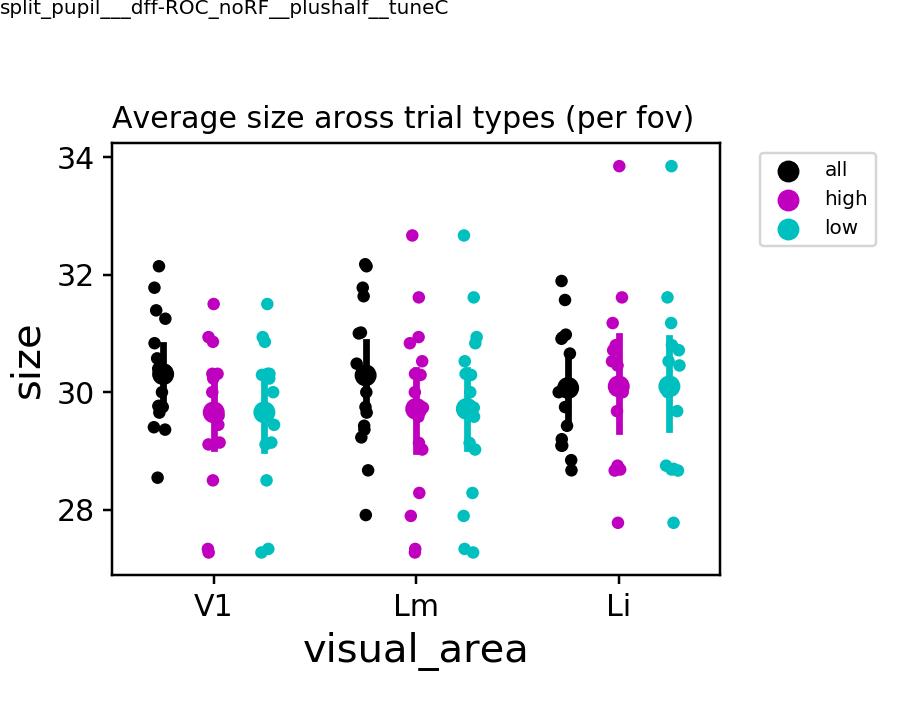

In [139]:
#### Get average size of stimulus across trials in each condition type
mean_size = pupil_input[pupil_input['train']].groupby(['visual_area', 'datakey', 'arousal']).mean().reset_index()

fig, ax = pl.subplots(figsize=(5,4))
sns.stripplot(x='visual_area', y='size', hue='arousal', data=mean_size, ax=ax,
             dodge=0.5, palette=arousal_colors, order=visual_areas)
sns.pointplot(x='visual_area', y='size', hue='arousal', data=mean_size, ax=ax,
             dodge=0.5, palette=arousal_colors, order=visual_areas, join=False)
ax.set_title("Average size aross trial types (per fov)", loc='left', fontsize=12)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=8)
pl.subplots_adjust(right=0.8, bottom=0.2, top=0.8)
putils.label_figure(fig, data_id)

figname = 'avg_sizes_by_fov_TRAIN__%s' % data_id
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))

## stimulus size x "arousal" (paired)

<IPython.core.display.Javascript object>


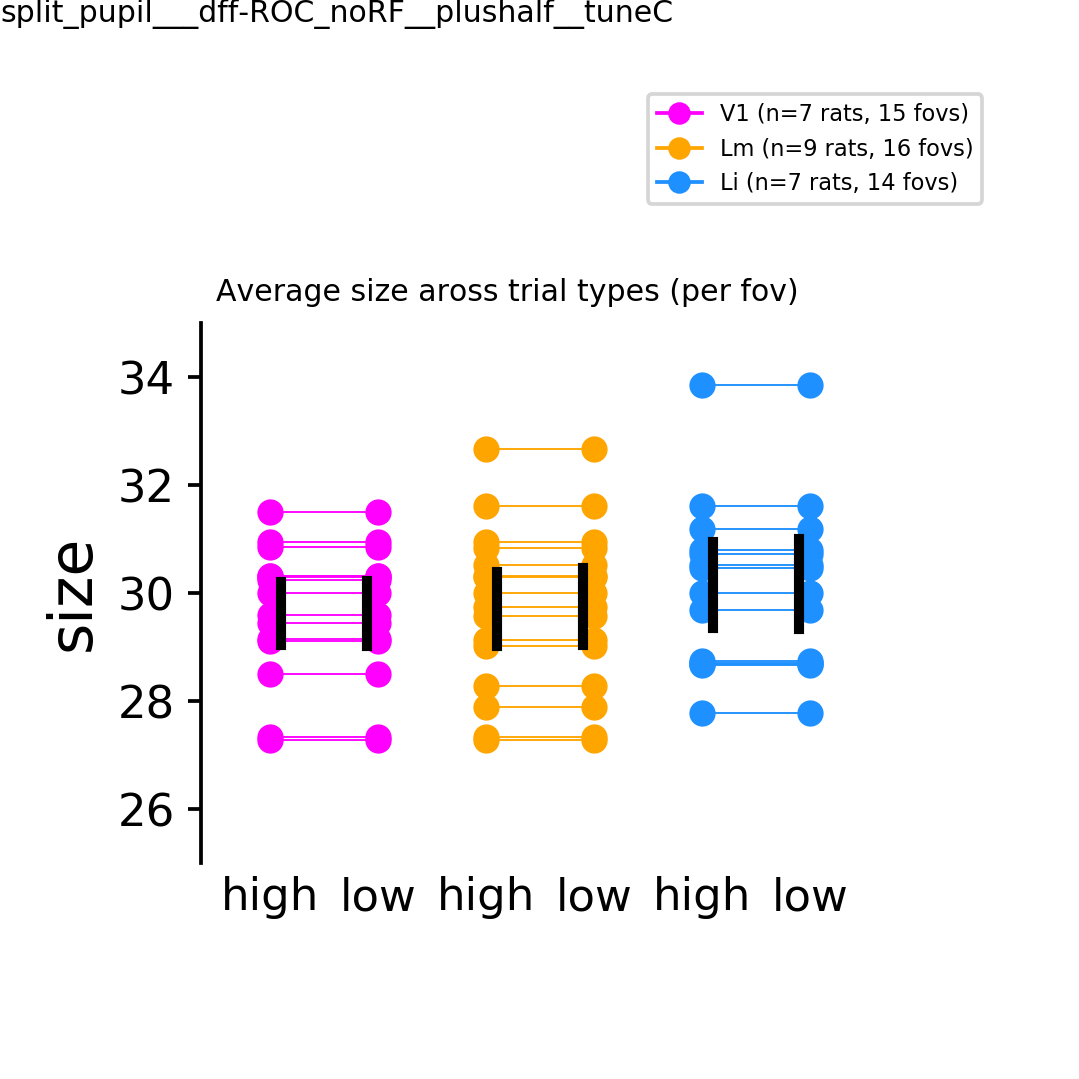

(t-stat:nan, p=nan)
(t-stat:nan, p=nan)
(t-stat:nan, p=nan)


In [141]:
c1='high'
c2='low'
compare_var='arousal'

df_ = mean_size[mean_size['arousal'].isin(['low', 'high'])].copy()

fig, ax = pl.subplots(figsize=(4,4), dpi=dpi)
for aix, visual_area in enumerate(visual_areas):
    plotd = df_[df_['visual_area']==visual_area]
    ax = aggr.plot_paired(plotd, aix=aix, curr_metric='size', c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, color=area_colors[visual_area])
sns.barplot("visual_area", 'size', data=df_, hue=compare_var, hue_order=[c1, c2], #zorder=0,
                ax=ax, order=visual_areas, errcolor='k', edgecolor='none', facecolor='none')
ax.set_xlabel('')

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df_, area_colors=area_colors,markersize=5, marker='o')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.2,1.2), loc='lower right', fontsize=6)
        
aggr.set_split_xlabels(ax, a_label=c1, b_label=c2)
df_.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fontcolor='k', xytext=(0,125))
ax.set_ylim([25, 35])
ax.set_title("Average size aross trial types (per fov)", loc='left', fontsize=8)

pl.subplots_adjust(bottom=0.2, left=0.2, wspace=0.5, top=0.7, right=0.8)
putils.label_figure(fig, data_id)


figname = 'avg_sizes_paired_by_fov_TRAIN__%s' % data_id
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


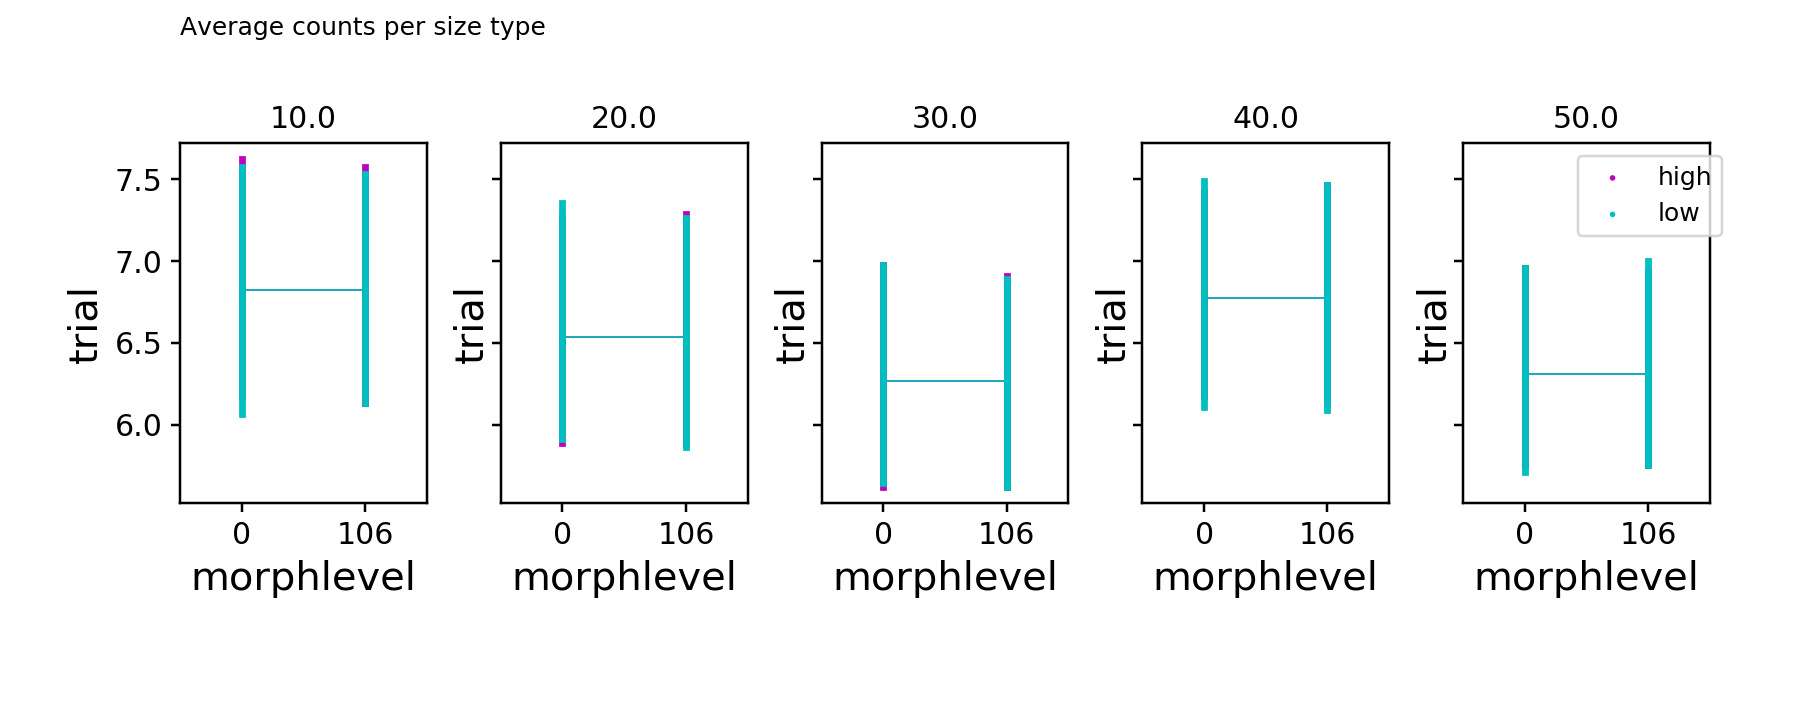

In [142]:
split_for_size = split_counts[(split_counts['train']) & (split_counts['arousal'].isin(['high', 'low']))].copy()

fig, axn = pl.subplots(1,5, figsize=(10,4), sharex=True, sharey=True)
arousal_colors={'all': 'k', 'high': 'm', 'low': 'c'}

for ai, (sz, d_) in enumerate(split_for_size.groupby(['size'])):
    
    ax = axn[ai]
    sns.pointplot(x='morphlevel', y='trial', hue='arousal', data=d_, ax=ax, 
                  dodge=False, join=True, lw=0.5, scale=0.25, palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
axn[-1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.3, top=0.8, wspace=0.3, hspace=0.3)

fig.text(0.1, 0.95, "Average counts per size type")


figname = 'counts_by_stim_size_TRAIN__%s' % data_id
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))

#### Plot which trial in session are high/lo arousal

<IPython.core.display.Javascript object>


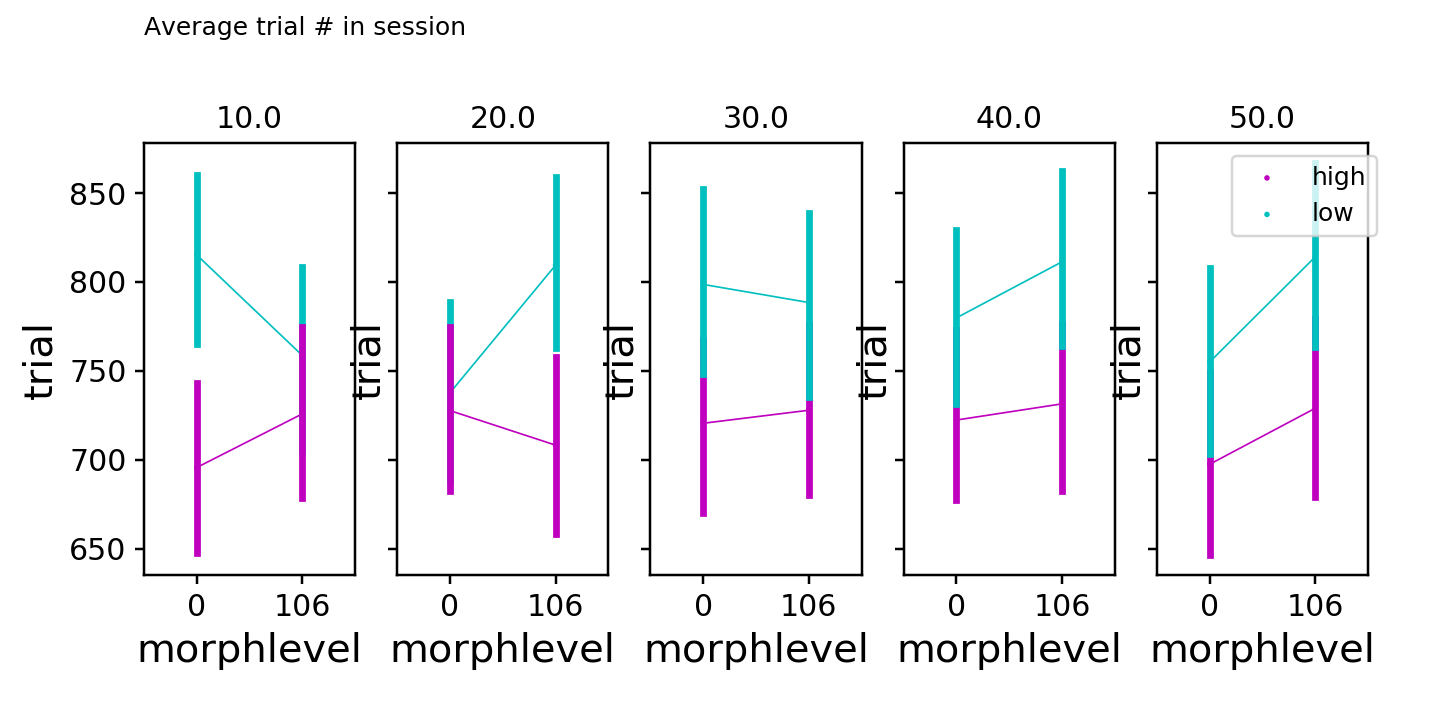

In [143]:
split_for_morph = pupil_input[(pupil_input['train']) & (pupil_input['arousal'].isin(['high', 'low']))].copy()


fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)
arousal_colors={'all': 'k', 'high': 'm', 'low': 'c'}

for ai, (sz, d_) in enumerate(split_for_morph.groupby(['size'])):
    
    ax = axn[ai]
    sns.pointplot(x='morphlevel', y='trial', hue='arousal', data=d_, ax=ax, 
                  dodge=False, join=True, lw=0.5, scale=0.25, palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
axn[-1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

fig.text(0.1, 0.95, "Average trial # in session")


figname = 'trialnum_by_stim_size_TRAIN__%s' % data_id
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))

In [256]:
neural_input.head()

visual_area              datakey     config  trial arousal cell  response
0          V1  20190511_JC083_fov1  config047    1.0    high    1  0.014118
1          V1  20190511_JC083_fov1  config021    2.0    high    1  0.007785
2          V1  20190511_JC083_fov1  config031    3.0    high    1  0.008554
3          V1  20190511_JC083_fov1  config032    4.0    high    1  0.002028
4          V1  20190511_JC083_fov1  config014    5.0     all    1 -0.020848

# Response magnitudes

In [144]:
means_by_cell = neural_input.groupby(['visual_area', 'datakey', 'cell', 'arousal' ]).mean().reset_index()
means_by_cell.head()

means_by_fov = means_by_cell.groupby(['visual_area', 'datakey', 'arousal' ]).mean().reset_index()
means_by_fov.head()

visual_area              datakey arousal        cell       trial  response
0          Li  20190314_JC070_fov1     all  220.857143  648.297735  0.014173
1          Li  20190314_JC070_fov1    high  220.857143  542.681004  0.015233
2          Li  20190314_JC070_fov1     low  220.857143  911.508961  0.015490
3          Li  20190316_JC070_fov1     all  125.714286  634.223114  0.009641
4          Li  20190316_JC070_fov1    high  125.714286  586.840220  0.011831

<IPython.core.display.Javascript object>


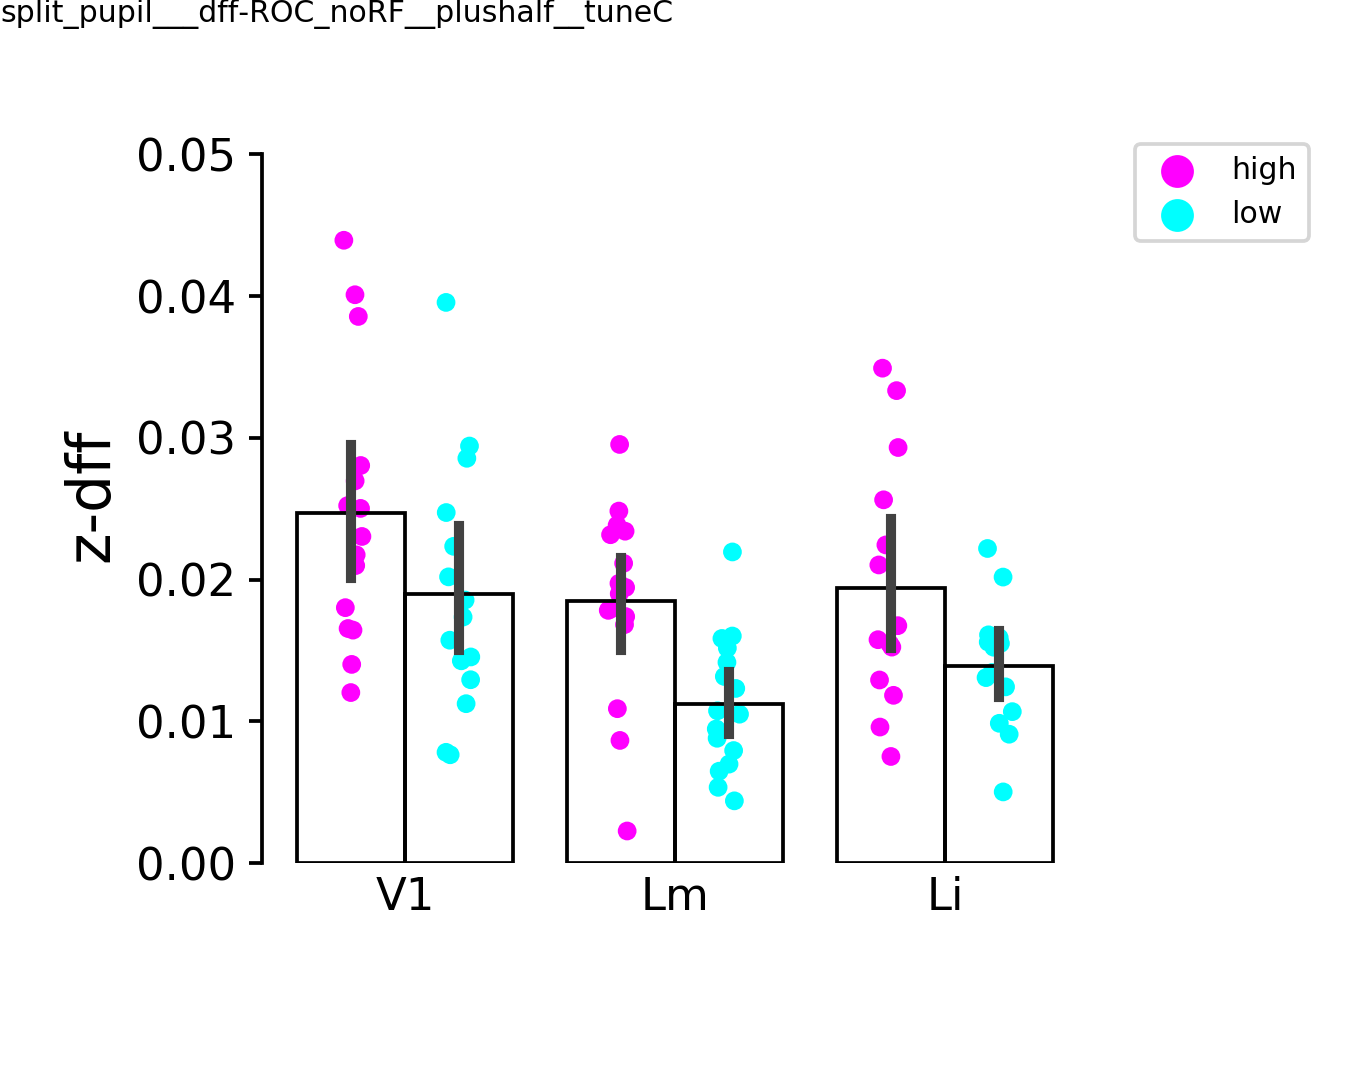

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC/controls', 'mean_dff_by_fov__filtered__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [145]:
palette=['magenta', 'cyan']
plot_cells=False

if plot_cells:
    plotdf = means_by_cell[means_by_cell['arousal'].isin(['high', 'low'])].copy()
else:
    plotdf = means_by_fov[means_by_fov['arousal'].isin(['high', 'low'])].copy()

markersize=2 if plot_cells else 5
plot_str='all_cells' if plot_cells else 'by_fov'

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

sns.stripplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, 
              palette=palette, dodge=True, zorder=-1, order=visual_areas, size=markersize)
sns.barplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, zorder=-1, 
            edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas)
plotdf.apply(aggr.annotateBars, ax=ax,fontsize=10, fontcolor='k', xytext=(0, -150))

#ax.set_ylim([-1, 2])
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('z-dff')

pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8)
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1., 1), fontsize=8)

putils.label_figure(fig, data_id)
#ax.set_ylim([-1, 2])
figname = 'mean_dff_%s__filtered__%s' % (plot_str, data_id)
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))
print(control_analysis_dir, figname)

<IPython.core.display.Javascript object>


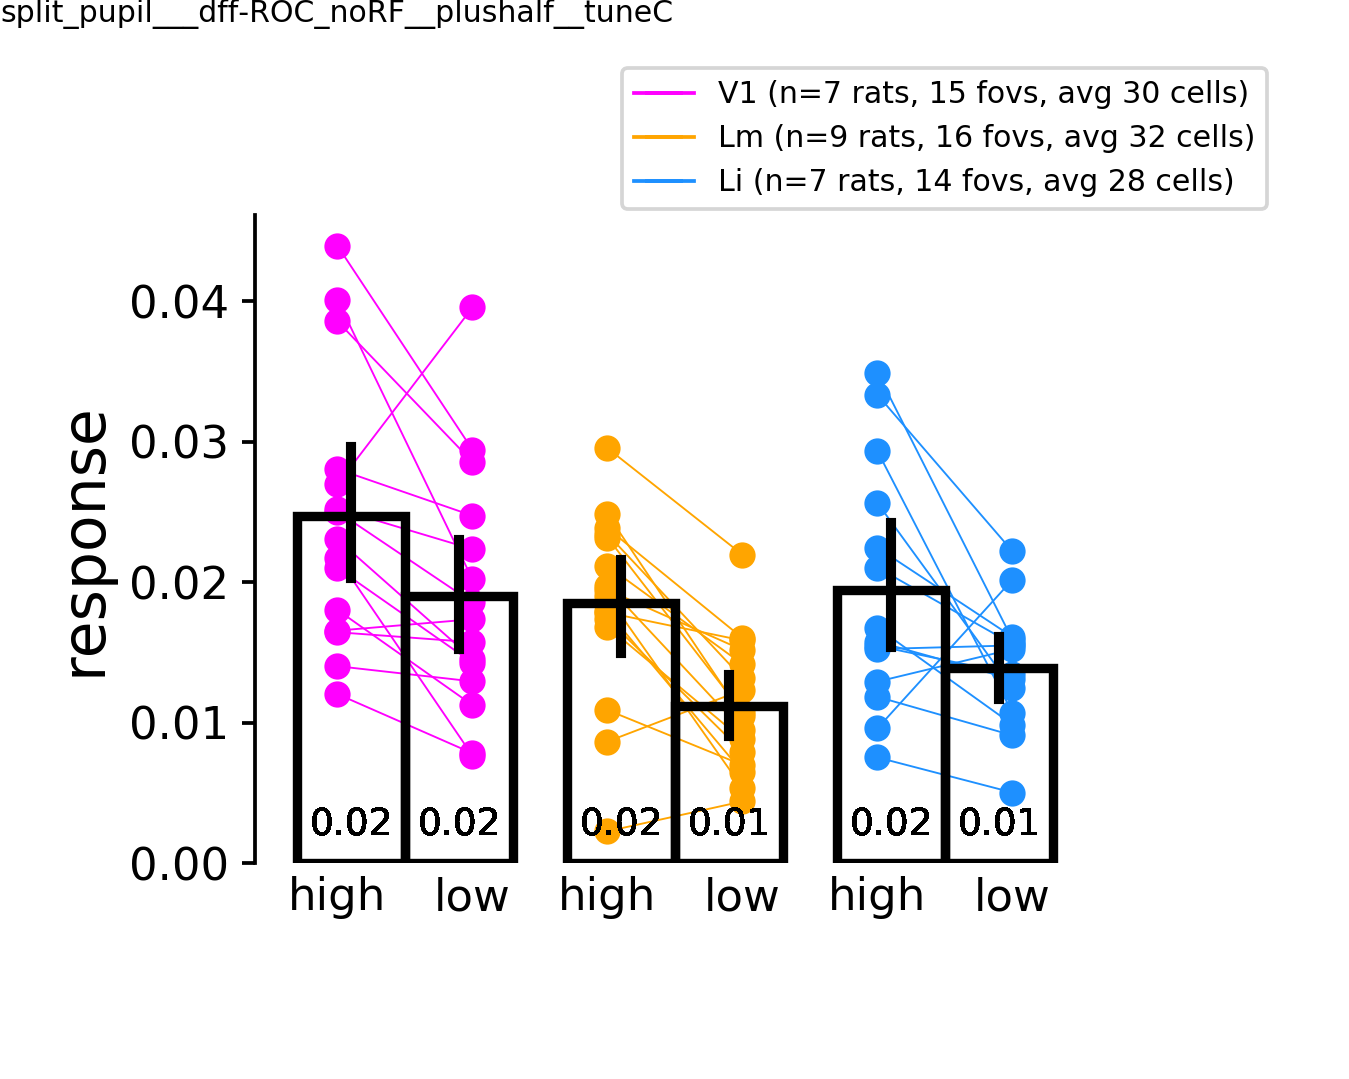

(t-stat:2.90, p=0.01)
(t-stat:5.55, p=0.00)
(t-stat:2.58, p=0.02)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC/controls', 'mean_dff_paired_by_fov__filtered__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [146]:
c1='high'
c2='low'
compare_var='arousal'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotdf, curr_metric='response', c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1.25, 1.25))
putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)
ax.set_xlabel('')

figname = 'mean_dff_paired_%s__filtered__%s' % (plot_str, data_id)
pl.savefig(os.path.join(control_analysis_dir, '%s.svg' % figname))
print(control_analysis_dir, figname)

In [255]:
plotd.head()

visual_area              datakey condition arousal         C  fit_time  \
133          V1  20190501_JC076_fov1      data    high   1.11034  0.000635   
134          V1  20190501_JC076_fov1      data     low   0.50752  0.000521   
175          V1  20190512_JC083_fov1      data    high   3.53440  0.001359   
176          V1  20190512_JC083_fov1      data     low  29.06713  0.006622   
187          V1  20190522_JC084_fov1      data    high   0.03880  0.000907   

     heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
133    0.043875     0.005383        0.063298            0.580714   
134    0.024059    -0.001602        0.034710            0.589286   
175    0.014278    -0.002692        0.020599            0.498235   
176    0.028373     0.002773        0.040933            0.566500   
187    0.236671     0.312963        0.341443            0.800000   

           ...          test_score  train_score  n_cells  n_trials  iteration  \
133        ...            0.588009     0.883730     33.0      67.0       49.5   
134        ...            0.625655     0.797239     33.0      67.0       49.5   
175        ...            0.528495     0.687433     28.0      83.0       49.5   
176        ...            0.578627     0.860733     28.0      97.0       49.5   
187        ...            0.781495     0.961402    107.0      90.0       49.5   

     fraction_missing  n_missing  n_pass  feature_sample_ratio  \
133          0.333333        100     200              0.165000   
134          0.333333        100     200              0.165000   
175          0.093548         29     281              0.099644   
176          0.093548         29     281              0.099644   
187          0.030000          9     291              0.367698   

     fold_over_shuffle  
133           0.113699  
134           0.061776  
175          -0.066152  
176           0.121782  
187           0.525424  

[5 rows x 21 columns]

In [256]:
import matplotlib.ticker as ticker


In [ ]:
plotd['feature_sample_ratio'] = plotd['n_cells']/plotd['n_pass']

In [ ]:
plotd['n_cells']

In [ ]:


fig, axn = pl.subplots(1, 2, figsize=(8,4), sharex=False)
ax=axn[0]
sns.scatterplot(x='n_cells', y='fraction_missing', hue='datakey', data=plotd, ax=ax, s=100)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.legend_.remove()

ax=axn[1]
sns.scatterplot(x='feature_sample_ratio', y=metric, hue='datakey', data=plotd, ax=ax, s=100)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))


pl.subplots_adjust(bottom=0.2, wspace=0.3, right=0.8, left=0.1)

In [ ]:
xlabels

In [ ]:
plotd[['datakey', 'arousal', 'n_trials', 'test_score', 'n_pass', 'n_cells', 'feature_sample_ratio']]

In [ ]:
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()


ax=axn[1]
sns.pointplot(x='arousal', y='n_cells', hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()

print(plotd[plotd['n_cells']<70]['datakey'])

In [ ]:
min_ncells=5

bad_training = df[df['test_score']<0.25]['datakey'].unique()
few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()

excluded = np.union1d(bad_training, few_cells)

print("Excluding %i datakeys for bad training: %s" % (len(bad_training), str(bad_training)))
print("Excluding %i datakeys for too few cells: %s" % (len(few_cells), str(few_cells)))


In [ ]:
meandf = df.groupby(['visual_area', 'datakey', 'condition', 'arousal']).mean().reset_index()
meandf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

In [ ]:
metric='heldout_log2MI'
plotdf = meandf[meandf['arousal'].isin(['low', 'high'])].copy()

fig, axn = pl.subplots(1,2, sharey=True)

ax=axn[0]; ax.set_title('data')
df_ = plotdf[plotdf['condition']=='data'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()

ax=axn[1]; ax.set_title('shuffled')
df_ = plotdf[plotdf['condition']=='shuffled'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()


## Check N trials per cond?

In [ ]:
ntrials_score = df.groupby(['datakey', 'arousal'])['heldout_test_score', 'n_trials'].mean().reset_index()

In [ ]:
fig, ax = pl.subplots(figsize=(4,3))

x1=ntrials_score[ntrials_score['arousal']=='high']
sns.regplot(x1['n_trials'], x1['heldout_test_score'], label='high')

x2=ntrials_score[ntrials_score['arousal']=='low']
sns.regplot(x2['n_trials'], x2['heldout_test_score'], label='low')

pl.legend()

## Check significance

In [ ]:
s_=[]
for (visual_area, datakey), d_ in df[df['arousal']=='all'].groupby(['visual_area', 'datakey']):
                            
    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    
    s = pd.Series({'visual_area': visual_area, 'datakey': datakey, 
                   'mean_score': mean_score, 'percentile': percentile})
    s_.append(s)
    
scores = pd.concat(s_, axis=1).T

In [ ]:
visual_area='Li'
scores[scores['visual_area']==visual_area]

In [ ]:
df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area'])['datakey'].count()


In [ ]:
area_dkeys = edata[edata['visual_area']=='V1']['datakey'].unique()
[k for k in area_dkeys if k not in df[df['visual_area']=='V1']['datakey'].unique()]
## NO cells.

In [ ]:
visual_area='Li'

plotdf = df[(df['arousal']=='all')] #& (df['visual_area']==visual_area)]

## plot
fig, axn = pl.subplots(3, 11, figsize=(10,5), sharex=True, sharey=True)
ai=0
prev_vi=0
for (visual_area, datakey), d_ in plotdf.groupby(['visual_area', 'datakey']):
    vi = visual_areas.index(visual_area)
    if prev_vi!=vi:
        ai=0
    ax = axn[vi, ai]
    if ai==0:
        ax.text(-0.3, 0.5*ai, visual_area)
        
    d_ = df[(df['arousal']=='all') & (df['datakey']==datakey) & (df['visual_area']==visual_area)]
    n_cells = d_['n_cells'].unique()[0]
    
    metric = 'heldout_test_score'
    
    sns.distplot(d_[d_['condition']=='data'][metric], ax=ax, bins=20, color='m')
    sns.distplot(d_[d_['condition']=='shuffled'][metric], ax=ax, bins=20, color='k')

    ax.set_title('%s\n(%i cells)' % (datakey, n_cells), fontsize=6, loc='left')
    #ax.axis('off')
    ai+=1
    prev_vi=vi
    
pl.subplots_adjust(left=0.05, right=0.95, wspace=0.5, hspace=0.5)

for ax in axn.flat:
    ax.axvline(x=0.5, linestyle=':', color='k')
    ax.axis('off')

## Threshold performance

In [ ]:
p_thr=0.01
pass_scores = scores[scores['percentile']<=p_thr]
pass_scores[pass_scores['visual_area']==visual_area]


In [ ]:
exclude_for_face ={'V1': ['20190510_JC083_fov1', '20190622_JC085_fov1', '20190617_JC097_fov1'],
                         #'20190507_JC083_fov1', '20190511_JC083_fov1'],
                  'Lm': ['20190506_JC080_fov1', '20190512_JC083_fov1'], 
                   'Li': []} #['20190502_JC076_fov1', '20191105_JC117_fov1', 
                          #'20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1'] }

#
visual_area='Li'

pass_dkeys = pass_scores[(pass_scores['visual_area']==visual_area)]['datakey'].unique()
exclude = list(meandf[~meandf['datakey'].isin(pass_dkeys)]['datakey'].unique())
exclude.extend(exclude_for_face[visual_area])

vdf = meandf[(meandf['visual_area']==visual_area) 
         & (~meandf['datakey'].isin(exclude))
         & (meandf['condition']=='data')]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']
fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3), fontsize=8)
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5, left=0.1)
fig.suptitle(visual_area)

print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [ ]:
dst_dir

In [ ]:
os.listdir(dst_dir)


# plotting

In [239]:
v1_exclude = ['20190510_JC083_fov1', '20190511_JC083_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1', '20190622_JC085_fov1']
lm_exclude=['20190506_JC080_fov1', '20190512_JC083_fov1', '20190513_JC078_fov1', '20190603_JC080_fov1']
li_exclude=['20190502_JC076_fov', '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1']


exclude = [v1_exclude, lm_exclude, li_exclude, excluded]
bad_dsets = [l for sublist in exclude for l in sublist ]
len(bad_dsets)

13

<IPython.core.display.Javascript object>


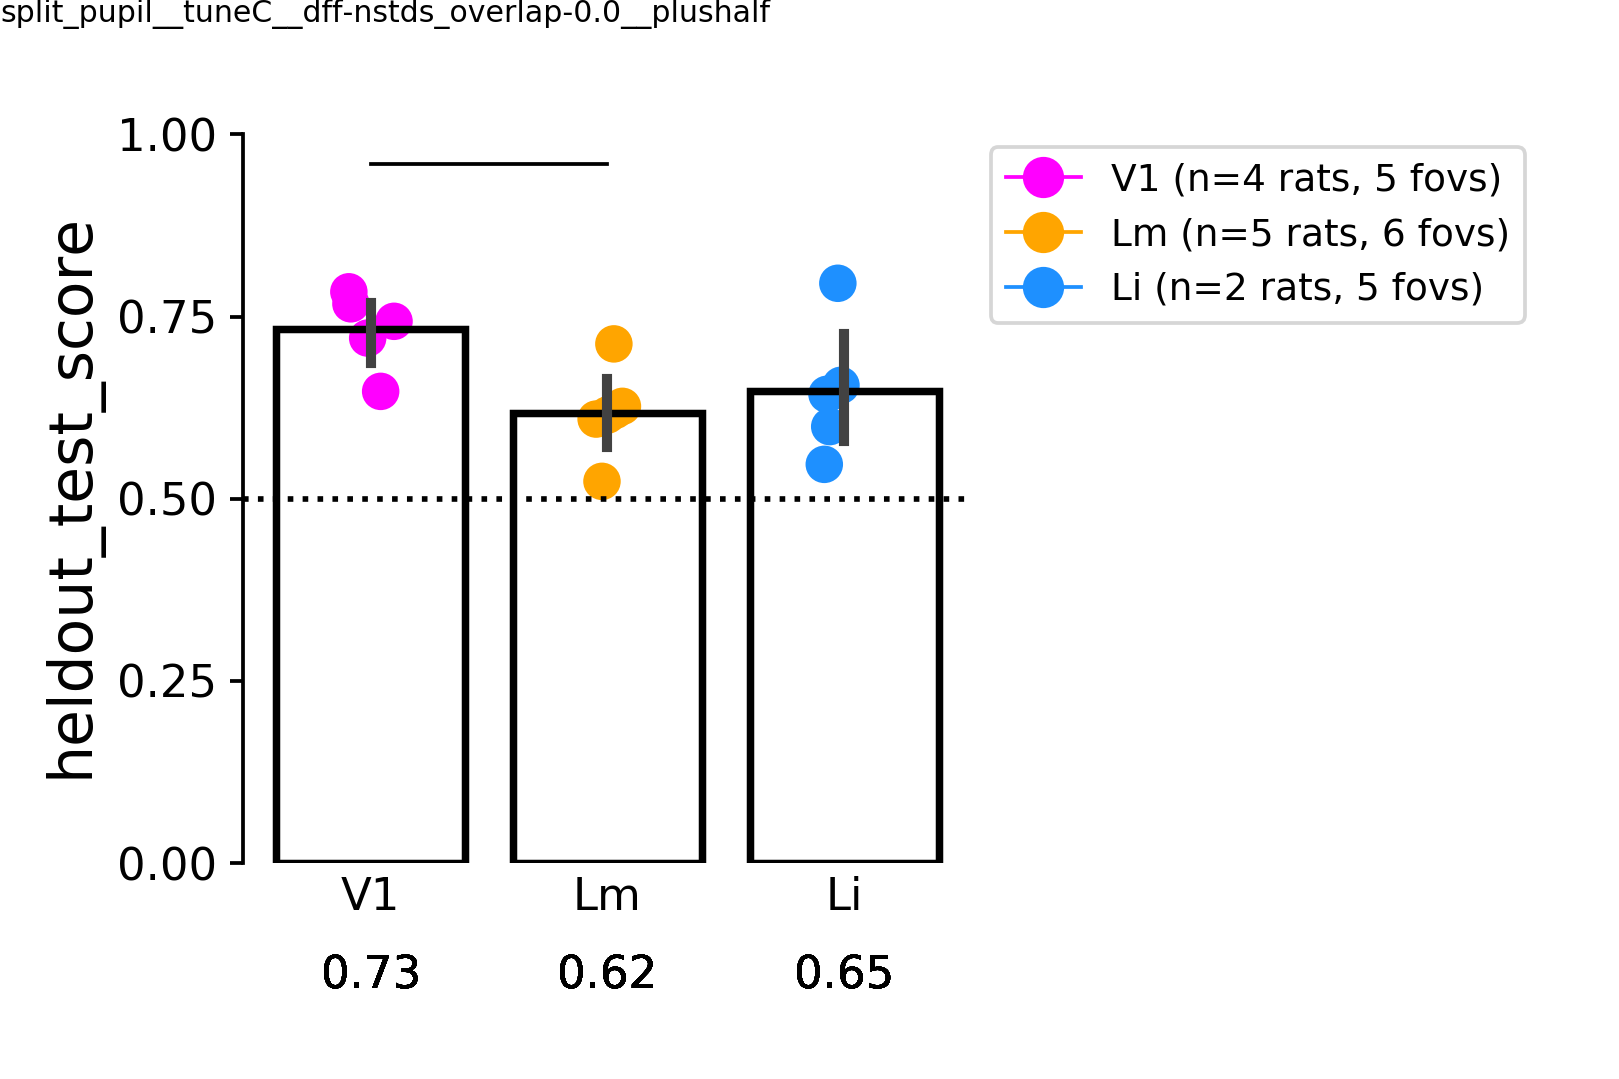

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.021 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.158 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.324 (fdr_bh), reject H0=False
****************************


In [47]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
multi_comp_test='fdr_bh'

f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

plotdf = df[~df['datakey'].isin(exclude)].copy()


if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy()

sns.barplot(x='visual_area', y=metric, data=xdf, ax=ax, order=visual_areas,
             edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=xdf, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=10)

xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))

ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

statsresults, ax = aggr.plot_mannwhitney(xdf, metric=metric, multi_comp_test=multi_comp_test, ax=ax)

leg = aggr.get_counts_for_legend(xdf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1))

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
sns.despine(bottom=True)
 
putils.label_figure(f, data_id)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.6)


# figname = 'overall_%s__%s' % (metric, data_id)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

<IPython.core.display.Javascript object>


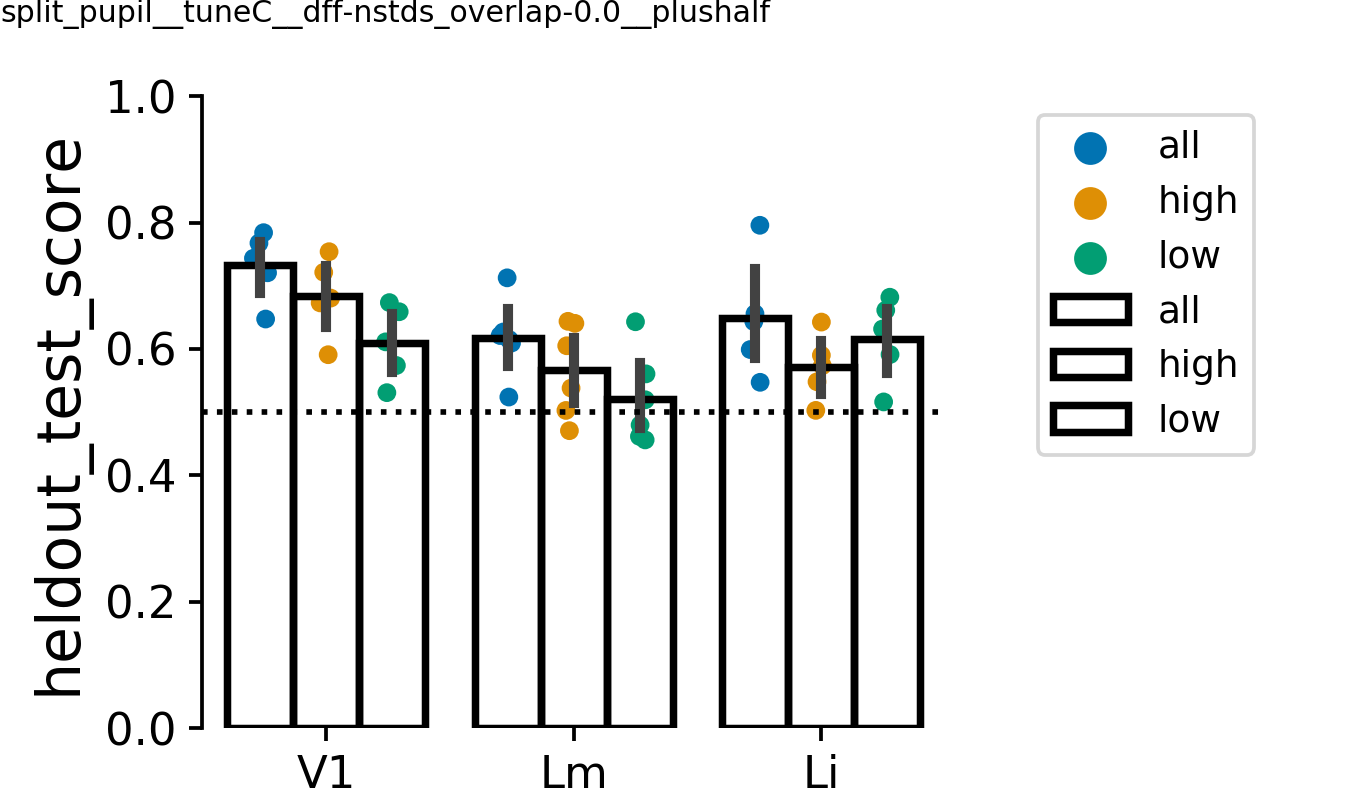

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'split_low-v-high_heldout_test_score__split_pupil__tuneC__dff-nstds_overlap-0.0__plushalf')


In [48]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, data_id)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [32]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov'

In [201]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


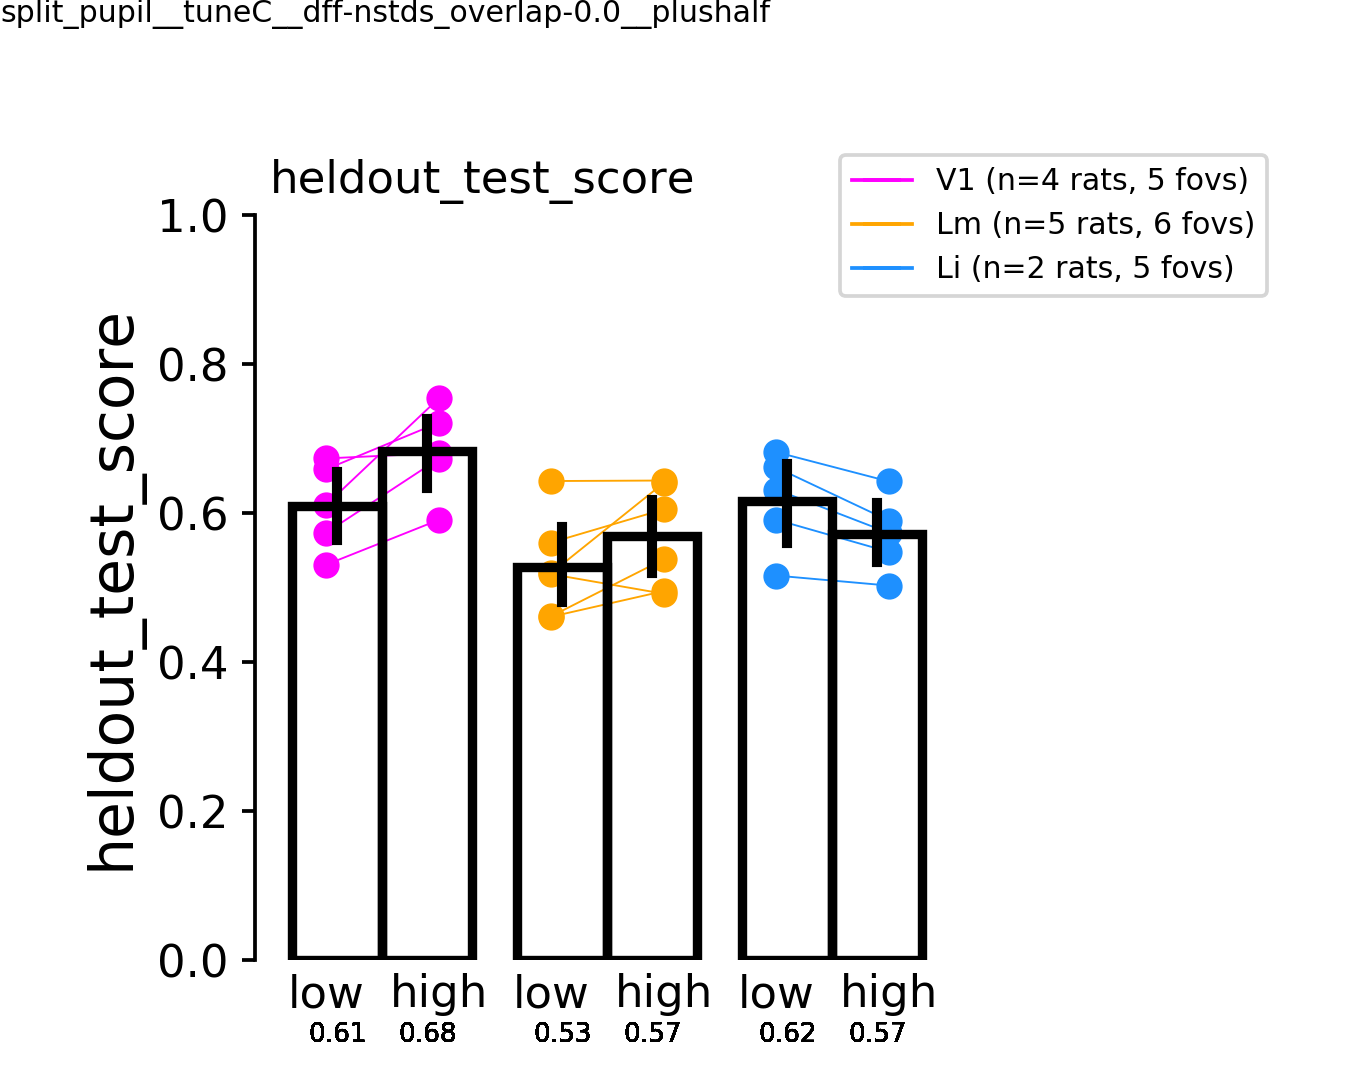

V1: (t-stat:-3.30, p=0.03)
Lm: (t-stat:-1.94, p=0.11)
Li: (t-stat:4.63, p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_test_score__tuneC')


<IPython.core.display.Javascript object>


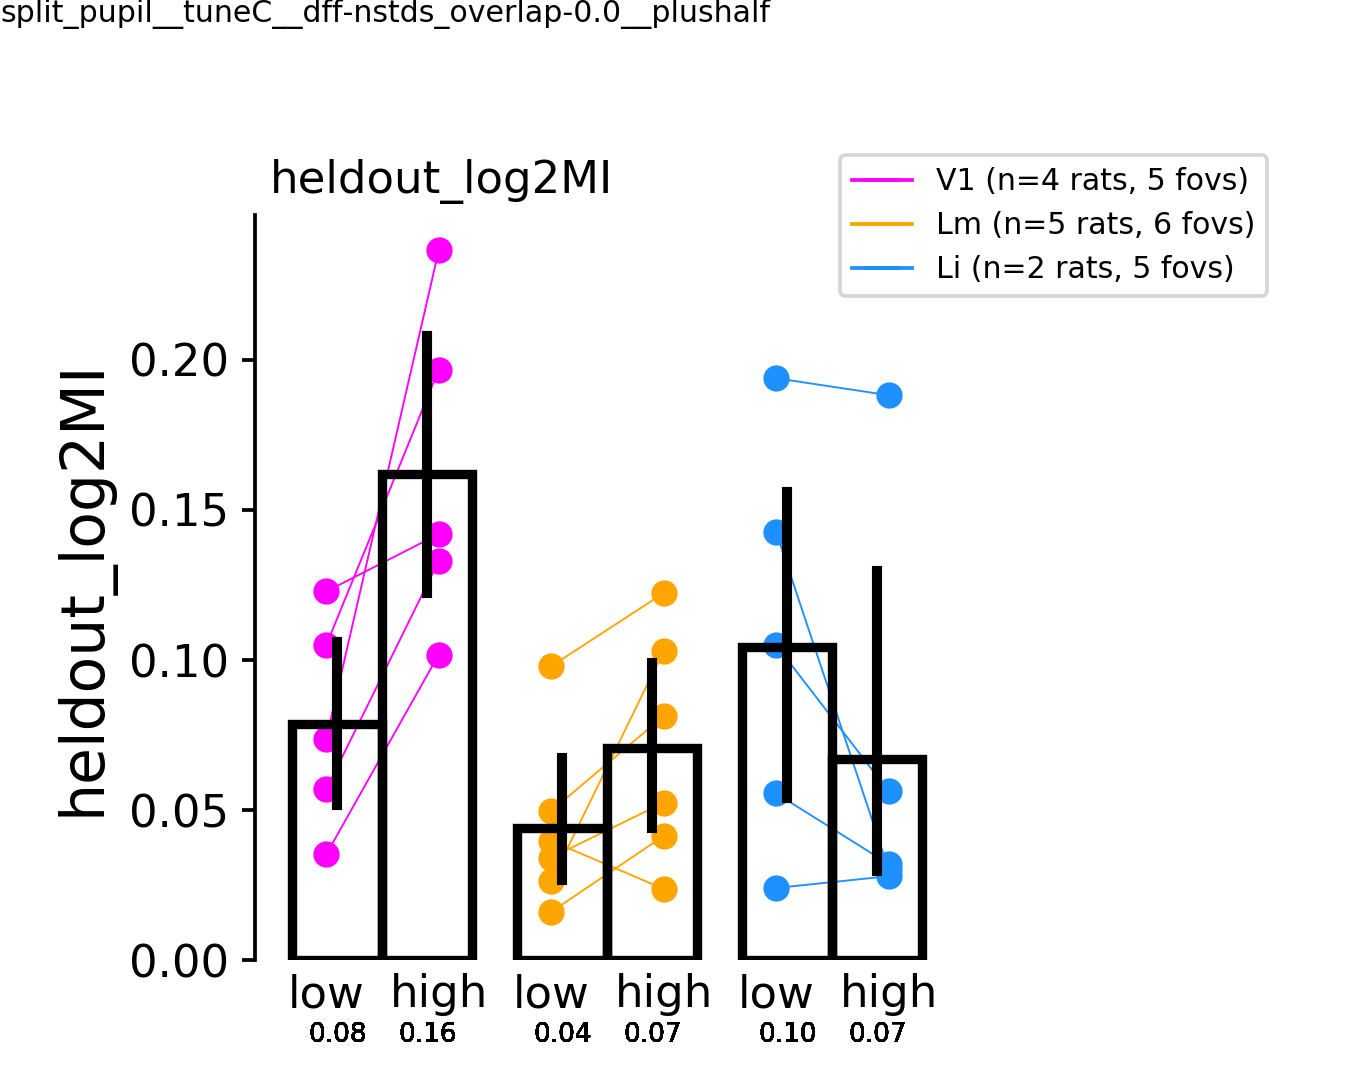

V1: (t-stat:-3.58, p=0.02)
Lm: (t-stat:-2.20, p=0.08)
Li: (t-stat:1.79, p=0.15)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_log2MI__tuneC')


<IPython.core.display.Javascript object>


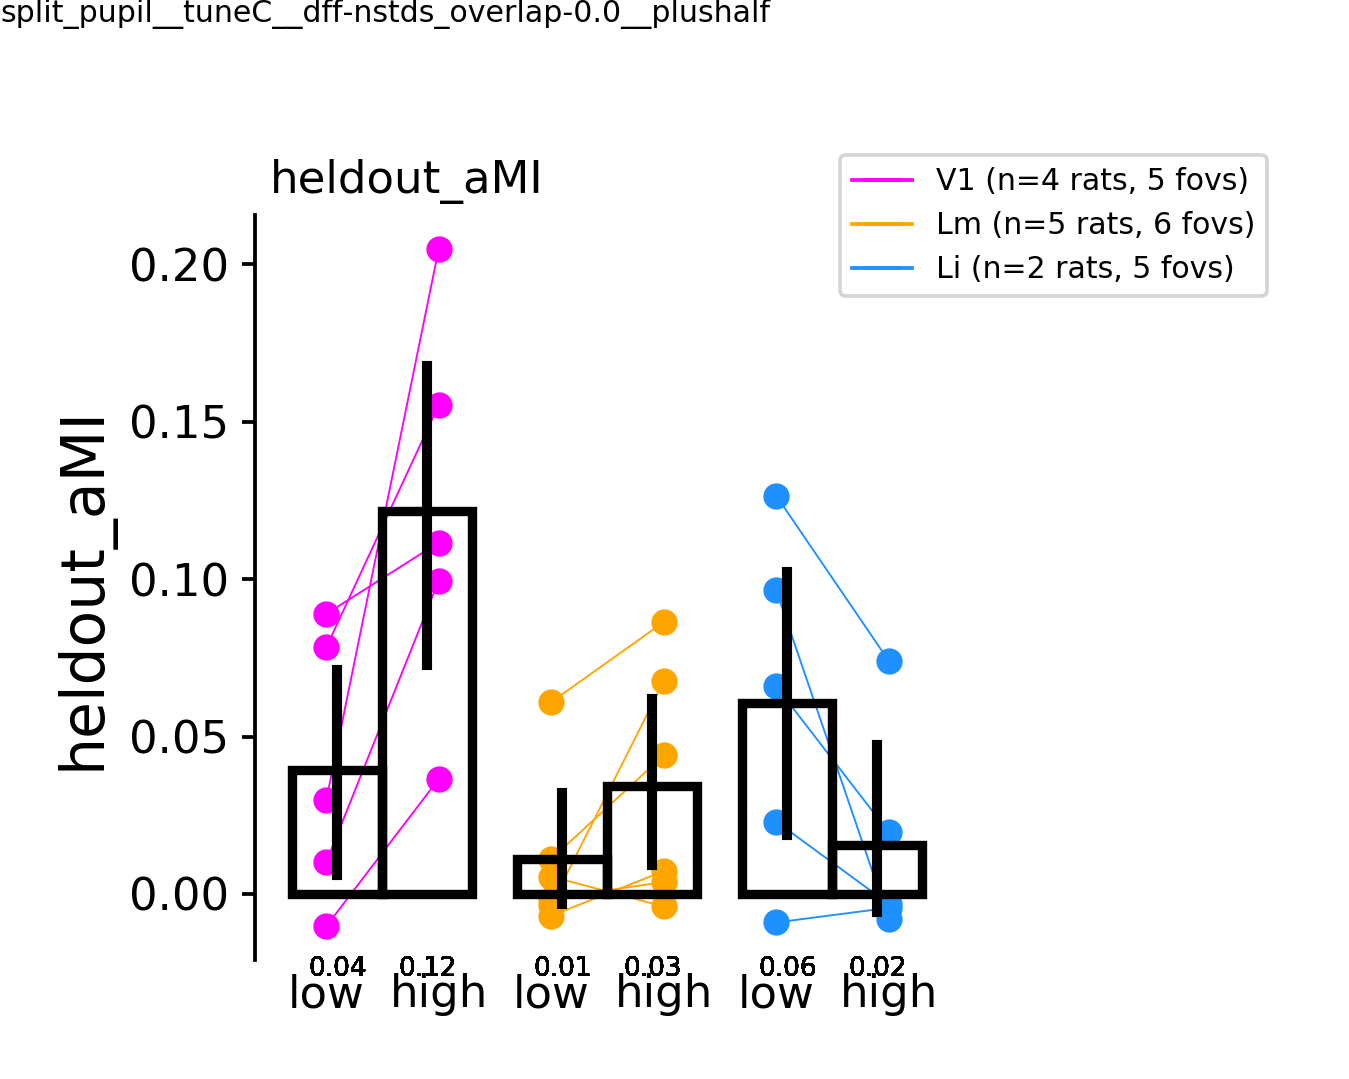

V1: (t-stat:-3.16, p=0.03)
Lm: (t-stat:-2.05, p=0.10)
Li: (t-stat:2.51, p=0.07)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_aMI__tuneC')


<IPython.core.display.Javascript object>


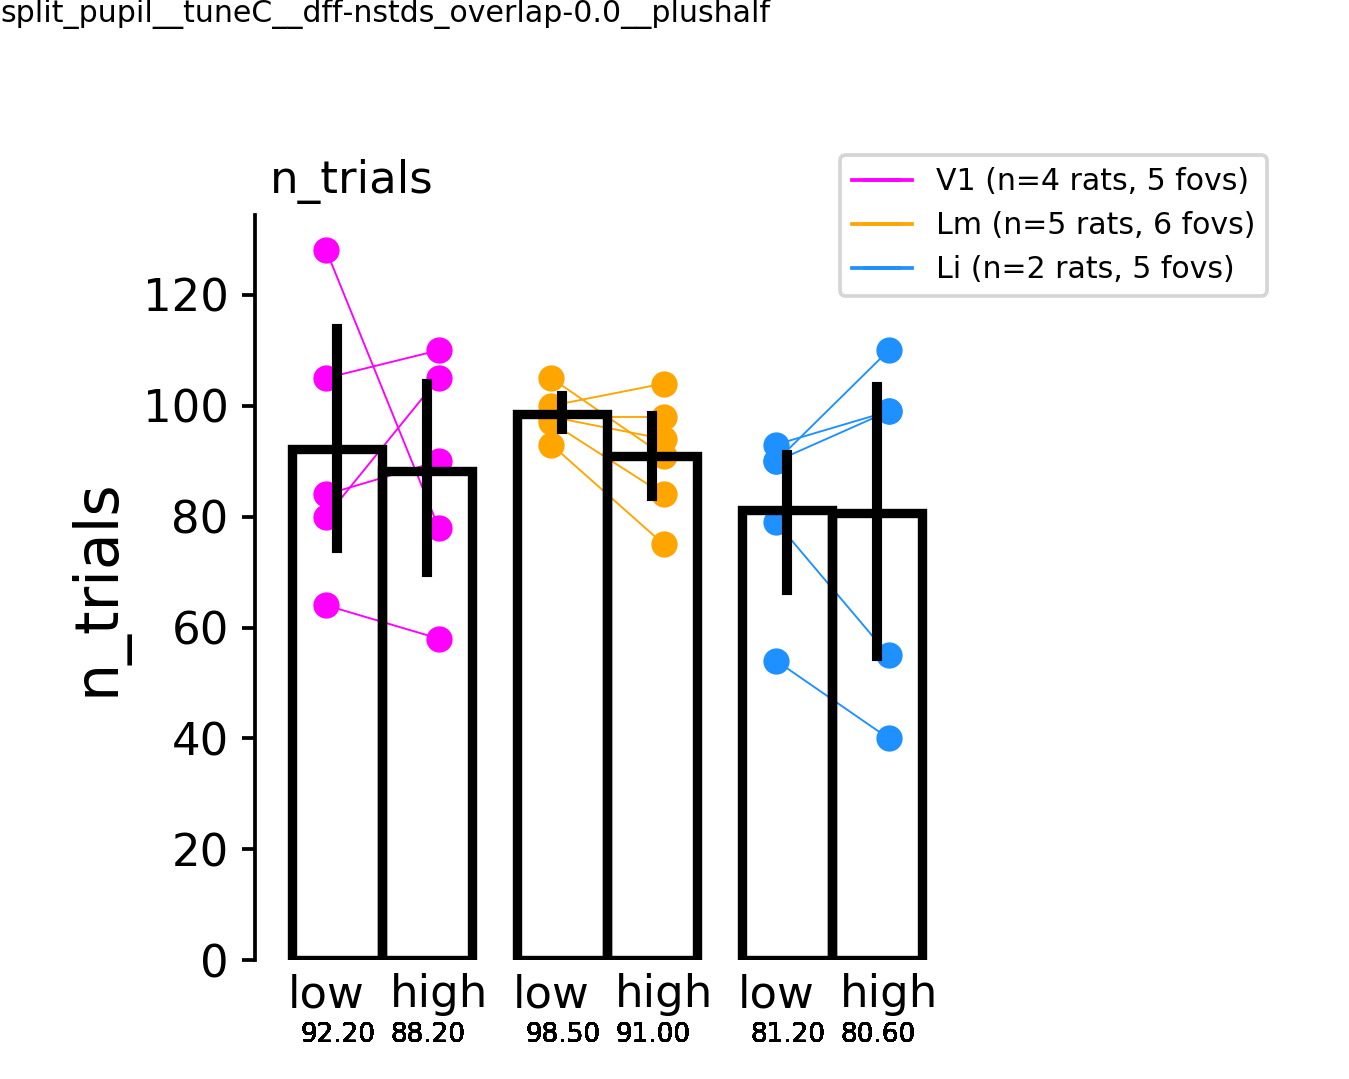

V1: (t-stat:0.32, p=0.77)
Lm: (t-stat:2.10, p=0.09)
Li: (t-stat:0.07, p=0.94)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_n_trials__tuneC')


In [196]:
metric = 'heldout_test_score'
#metric = 'abs_coef'
plotdf = df[~df['datakey'].isin(exclude)].copy()

currdf = plotdf[(plotdf['arousal'].isin(['low', 'high'])) & (~plotdf['datakey'].isin(exclude))]


for metric in ['heldout_test_score', 'heldout_log2MI','heldout_aMI', 'n_trials']:
    fig = aggr.plot_pairwise_by_axis(currdf, curr_metric=metric, c1='low', c2='high', compare_var='arousal',
                               area_colors=area_colors, fontsize=7, fontcolor='k', fmt='%.2f', xytext=(0, -20))
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    if metric=='heldout_test_score':
        fig.axes[0].set_ylim([0, 1])
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


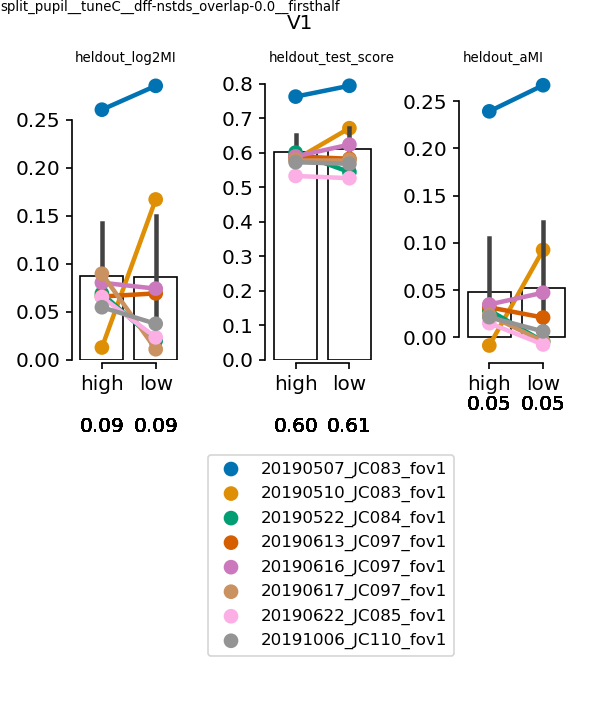

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-0.05 (p=0.96)
heldout_test_score--------------------
Paired t-test, t=0.68 (p=0.52)
heldout_aMI--------------------
Paired t-test, t=0.26 (p=0.81)
test_metrics_V1_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0__firsthalf


In [241]:
exclude =[] #copy.copy(v1_exclude)
#exclude=[]
visual_area='V1'

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)


figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#|pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


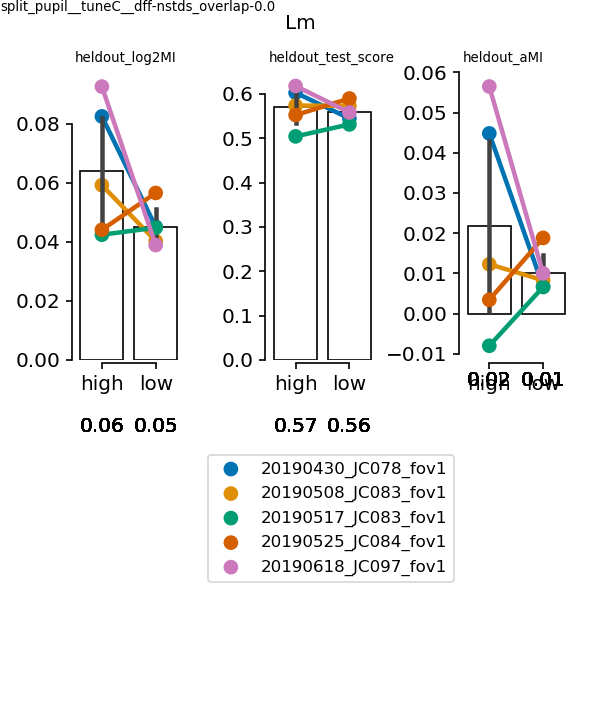

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=-1.56 (p=0.19)
heldout_test_score--------------------
Paired t-test, t=-0.52 (p=0.63)
heldout_aMI--------------------
Paired t-test, t=-0.90 (p=0.42)
test_metrics_Lm_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [205]:
exclude=copy.copy(lm_exclude)
visual_area='Lm'
vdf = plotdf[(plotdf['visual_area']==visual_area) & (~plotdf['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


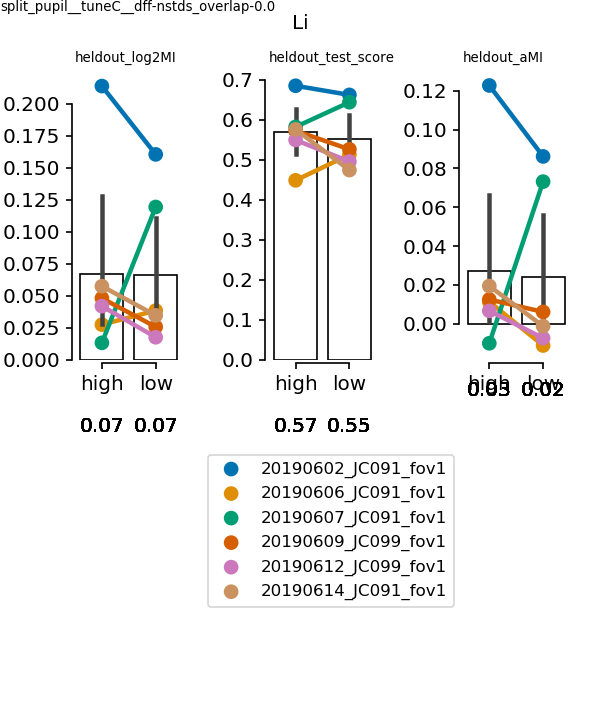

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=-0.04 (p=0.97)
heldout_test_score--------------------
Paired t-test, t=-0.61 (p=0.57)
heldout_aMI--------------------
Paired t-test, t=-0.16 (p=0.88)
test_metrics_Li_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [208]:
# exclude=['20190506_JC080_fov1', '20190512_JC083_fov1']
exclude = [] #copy.copy(li_exclude)
visual_area='Li'


#plotdf = df[~df['datakey'].isin(bad_dsets)].copy()

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [104]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [109]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [112]:

pupil_feature='pupil_fraction'
pupil_epoch = 'stimulus'
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, feature_name=pupil_feature,
                               trial_epoch=pupil_epoch, alignment_type='trial', 
                               in_rate=pupil_framerate, out_rate=pupil_framerate, 
                               iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur, create_new=True)


~~~~~ Aggregating pupil traces. ~~~~~~
Aggregated pupil traces. Missing 2 datasets.
20190422_JC076_fov1
20191008_JC091_fov1
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_stimulus_snapshot-391800.pkl


<IPython.core.display.Javascript object>


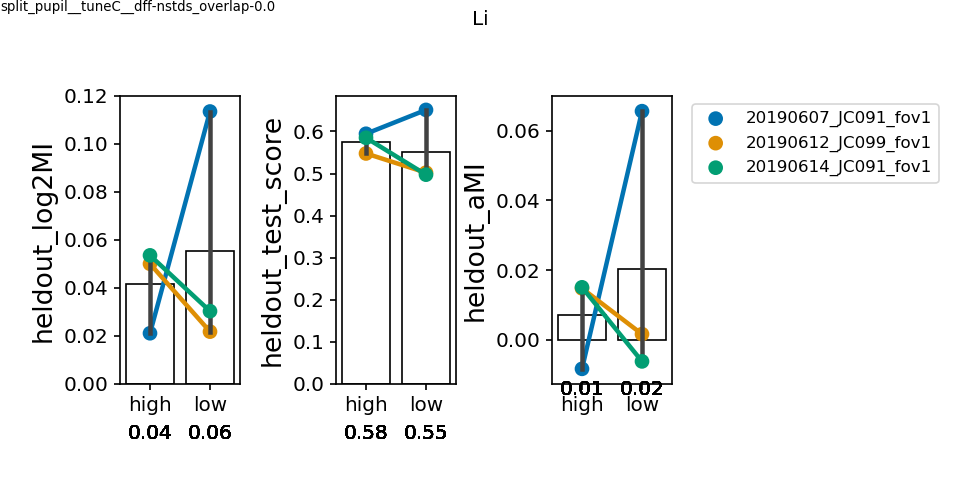

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=0.35 (p=0.76)
heldout_test_score--------------------
Paired t-test, t=-0.59 (p=0.61)
heldout_aMI--------------------
Paired t-test, t=0.43 (p=0.71)


<IPython.core.display.Javascript object>


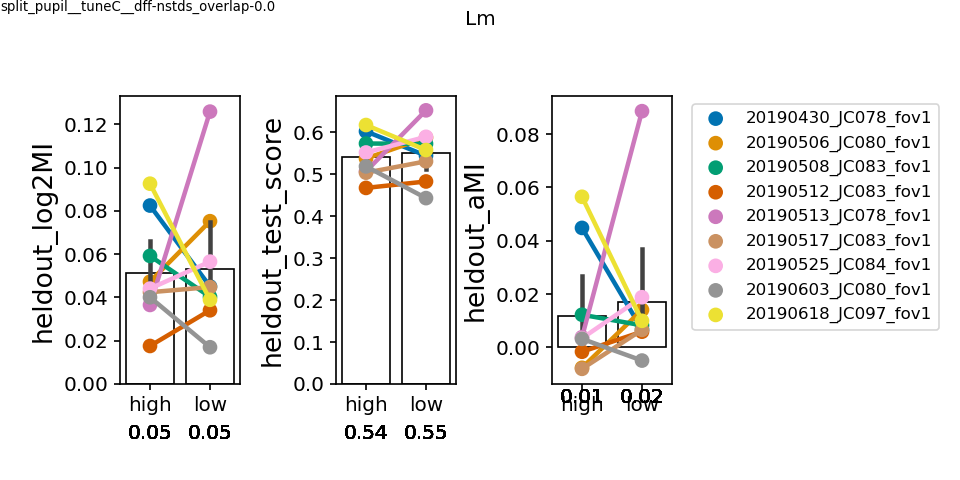

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=0.12 (p=0.91)
heldout_test_score--------------------
Paired t-test, t=0.39 (p=0.70)
heldout_aMI--------------------
Paired t-test, t=0.41 (p=0.69)


<IPython.core.display.Javascript object>


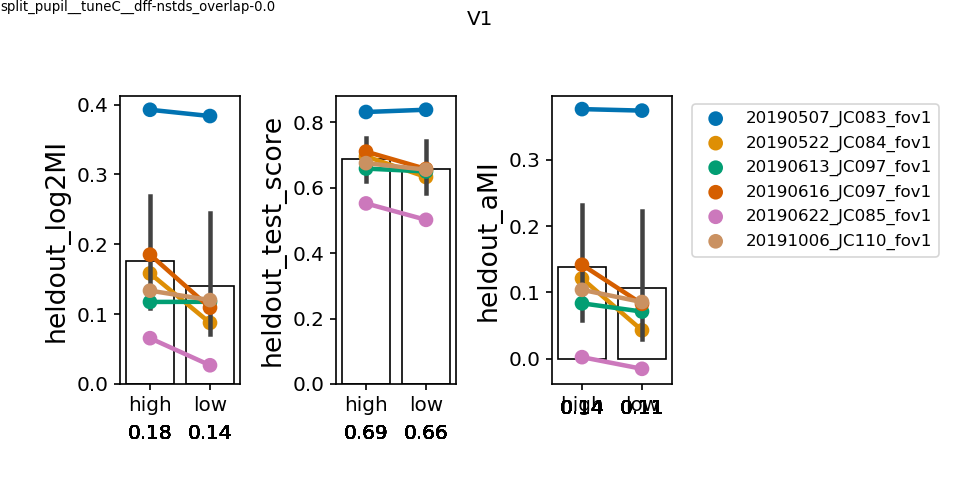

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-2.59 (p=0.05)
heldout_test_score--------------------
Paired t-test, t=-2.74 (p=0.04)
heldout_aMI--------------------
Paired t-test, t=-2.55 (p=0.05)


In [71]:

for visual_area, vdf in plotdf[~plotdf['datakey'].isin(exclude)].groupby(['visual_area']):

    xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        
        sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        
        xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = xdf[(xdf['arousal']=='low')][metric]
        b = xdf[(xdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    #C_str = 'C-%.2f' % C_value if C_value is not None else 'tuneC'
    #figname = '%s_%s_morph%iv%i_%s_%i-iters' % (face_feature, visual_area, m0, m100, C_str, n_iterations)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' %figname))
    #print(dst_dir, figname)

# By FOV

# Filter bad stuff

In [46]:
#### Calculate overlap with stimulus
stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)

In [47]:
remove_too_few = True
min_ncells=0
overlap_thr=0.5

####
globalcells, cell_counts = decutils.get_pooled_cells(stim_overlaps, remove_too_few=remove_too_few,
                                                     overlap_thr=overlap_thr, min_ncells=min_ncells)


             cell
visual_area      
Li            181
Lm            299
V1            766
('V1', 766)
('Lm', 299)
('Li', 181)


In [49]:
pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
counts_by_dset = aggr.get_counts_by_datakey(pass_overlaps)
counts_by_dset.groupby(['visual_area']).sum()

n_cells  fovnum
visual_area                 
Li               181      10
Lm               299      13
V1               766      17

In [ ]:
dst_dir


<IPython.core.display.Javascript object>


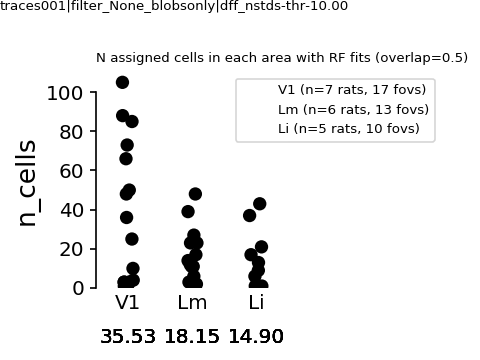

In [226]:
f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
sns.stripplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.barplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='w', errcolor='w')
counts_by_dset.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))


ax.tick_params(which='both', axis='x', size=0)
ax.set_ylim([0, ax.get_ylim()[-1]])
sns.despine(bottom=True, trim=True, ax=ax)

ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells in each area with RF fits (overlap=%.1f)" % overlap_thr, loc='left', fontsize=8)
putils.label_figure(f, data_id)

leg = aggr.get_counts_for_legend(counts_by_dset, markersize=0, lw=0)
ax.legend(handles=leg, bbox_to_anchor=(1.8,1), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.6, bottom=0.2)

figname = 'ncells_assigned_with_rfs__%s-%s__match-Li-distn' % (response_type, responsive_test)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


# Decode

In [17]:

test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


#### Test boot iter for 1 cell

In [23]:
curr_ncells = 1
gdf = globalcells[globalcells['visual_area']=='V1'].copy() # globalcells for current visual_area


In [24]:
visual_area = 'V1'

datakey = '20190613_JC097_fov1'
sdf = SDF[datakey]
gdf = globalcells[globalcells['visual_area']==visual_area].copy() # globalcells for current visual_area

rid = 2
rid in gdf['dset_roi']


True

In [25]:
curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)
assert len(curr_data['config'].value_counts().unique())==1, "(%s) ERR: uneven trial counts by config" % datakey


(1500, 2)


In [26]:
n_iterations=100

i_=[]; s_=[];
for inum in np.arange(0, n_iterations):
    it_df, sh_df = decutils.do_fit_within_fov(inum, curr_data=curr_data, sdf=sdf, return_shuffle=True,
                                        C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
                                        class_a=class_a, class_b=class_b)
    i_.append(it_df)
    s_.append(sh_df)
    
iterdf = pd.concat(i_, axis=0)
shufdf = pd.concat(s_, axis=0)
iterdf.mean()

<IPython.core.display.Javascript object>


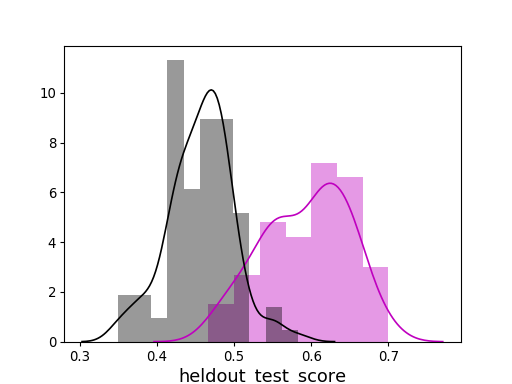

In [29]:
metric='heldout_test_score'
ci=0.95

f, ax = pl.subplots()
sns.distplot(iterdf[metric], color='m')
sns.distplot(shufdf[metric], color='k')

# ci_lo, ci_hi = putils.get_empirical_ci(iterdf[metric].values, ci=ci)
# ax.axvline(x=ci_lo, linestyle=':', c='k')
# ax.axvline(x=ci_hi, linestyle=':', c='k')

In [8]:
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                              rootdir='/n/coxfs01/2p-data'):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    sub_dir = '%s-%s' % (response_type, responsive_test)
    #print(sub_dir)
    C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
    cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))

    #print("... %i cell results" % len(cell_results))

    rlist=[]
    for c in cell_results:
        with open(c, 'rb') as f:
            r_ = pkl.load(f)
        means_ = r_.mean()
        non_num = [i for i in r_.columns if i not in means_.index]
        #metainfo = dict((k, r_[k].unique()[0]) for k in non_num)
        for k in non_num:
            means_[k] = r_[k].unique()[0]
        means_ = pd.to_numeric(r_.mean())

        rlist.append(means_)
        
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=1).T
    
    return roidf


In [ ]:
# INFO:  [7763640]: 20190507_JC083_fov1_V1_tuneC
# INFO:  [7763651]: 20190522_JC084_fov1_V1_tuneC   
        
# INFO:  [7763654]: 20190613_JC097_fov1_V1_tuneC 
# INFO:  [7763657]: 20190616_JC097_fov1_V1_tuneC 
# INFO:  [7763659]: 20190617_JC097_fov1_V1_tuneC
# INFO:  [7763661]: 20190622_JC085_fov1_V1_tuneC
# INFO:  [7763664]: 20191006_JC110_fov1_V1_tuneC

In [9]:
rootdir='/n/coxfs01/2p-data'
traceid='traces001'
experiment='blobs'
# -----------------------------------------------------
response_type='dff'
responsive_test='nstds'
# -----------------------------------------------------


In [ ]:
visual_area = 'Li'
animalid = 'JC091'
session = '20190614'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

# curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
roidf = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
                                   C_value=None, response_type=response_type, responsive_test=responsive_test,
                                   rootdir=rootdir)
curr_ncells = roidf.shape[0]
metainfo = {'datakey': datakey, 'visual_area': visual_area}
roidf = putils.add_meta_to_df(roidf, metainfo)


In [20]:
print(roidf.shape)
sub_dir = '%s-%s' % (response_type, responsive_test)
print(sub_dir)
C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                        'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                        'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))
print(len(cell_results))

(37, 14)
dff-nstds
37


<IPython.core.display.Javascript object>


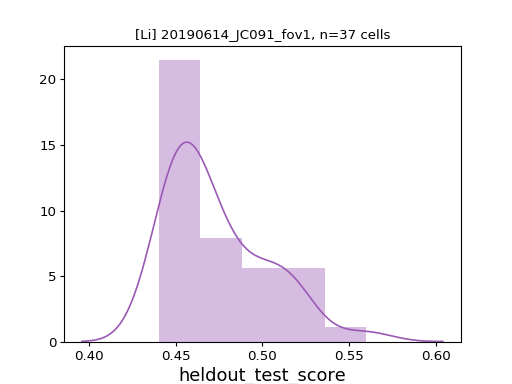

Text(0.5,1,u'[Li] 20190614_JC091_fov1, n=37 cells')

In [21]:
fig, ax = pl.subplots()
sns.distplot(roidf['heldout_test_score'], ax=ax)
ax.set_title("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))



In [10]:
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in globalcells.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    roidf = load_cell_results_from_fov(animalid, session, 'FOV%i_zoom2p0x' % fovnum, experiment, traceid=traceid,rootdir=rootdir)
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    curr_ncells = roidf.shape[0]
    print("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)
singledf = pd.concat(r_list, axis=0)

NameError: name 'globalcells' is not defined

In [ ]:
INFO:  [7985264]: 20190430_JC078_fov1_Lm_tuneC
INFO:  [7985267]: 20190506_JC080_fov1_Lm_tuneC
INFO:  [7985271]: 20190513_JC078_fov1_Lm_tuneC
INFO:  [7985273]: 20190525_JC084_fov1_Lm_tuneC
INFO:  [7985276]: 20190618_JC097_fov1_Lm_tuneC
INFO:  [7985274]: 20190603_JC080_fov1_Lm_tuneC
        
INFO:  [7985265]: 20190504_JC078_fov1_Lm_tuneC
INFO:  [7985268]: 20190508_JC083_fov1_Lm_tuneC
INFO:  [7985269]: 20190509_JC078_fov1_Lm_tuneC
INFO:  [7985270]: 20190512_JC083_fov1_Lm_tuneC
INFO:  [7985272]: 20190517_JC083_fov1_Lm_tuneC
INFO:  [7985277]: 20190627_JC091_fov1_Lm_tune


In [47]:
min_ncells=60
curr_dkeys = [k for k, g in singledf.groupby(['datakey']) if len(g)<min_ncells]

<IPython.core.display.Javascript object>


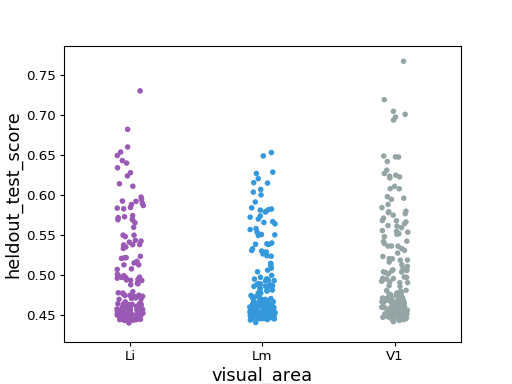

In [49]:
metric='heldout_test_score'

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, data=singledf[singledf['datakey'].isin(curr_dkeys)], ax=ax)

In [28]:
singledf.groupby(['visual_area']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
visual_area                                                                
Li           8.390145  0.001162    0.011191     0.008852        0.016145   
Lm           7.421948  0.001123    0.008848     0.005680        0.012765   
V1           7.736929  0.001147    0.012561     0.010258        0.018121   

             heldout_test_score  n_cells    n_trials  score_time  test_score  \
visual_area                                                                    
Li                     0.498520      1.0  296.392405    0.000312    0.540805   
Lm                     0.488769      1.0  296.011236    0.000319    0.533930   
V1                     0.508667      1.0  303.130755    0.000292    0.546073   

             train_score        cell  
visual_area                           
Li              0.545417  152.436709  
Lm              0.538750  116.831461  
V1              0.550571  107.425414

<IPython.core.display.Javascript object>


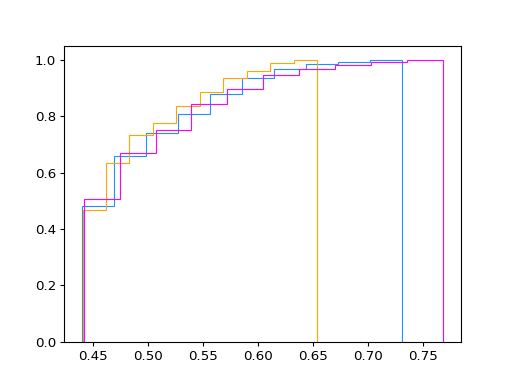

In [51]:
metric='heldout_test_score'
fig, ax = pl.subplots()
# for visual_area, vdf in singledf.groupby(['visual_area']):
#     sns.distplot(vdf[metric].values, color=area_colors[visual_area], ax=ax, kde=False, #bins=100,
#                 hist_kws={"histtype": "step", "linewidth": 3})

xdf = singledf[singledf['datakey'].isin(curr_dkeys)]
for visual_area, vdf in xdf.groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                                density=True, histtype='step', cumulative=True)
    
    
